We aren't given any labels for hit/miss, so I assume we're supposed to predict this ourselves.

I.e. hypothesis: Neuroplasticity becomes stronger from use of FES
 - We can find correlation from EEG signals and movement of robot
 - make our own model to predict and give binary classification matrix/report

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.signal import welch, butter, filtfilt, iirnotch

import seaborn as sns
import copy

In [2]:
# constants
fs = 512 # gotten from xdf files

This code is to parse split the messed up session into normal sessions

In [ ]:
# run = run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FESFIRSTHALF_NOFESSECONDHALF_task-Default_run-001_eeg.csv'),pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FESFIRSTHALF_NOFESSECONDHALF_task-Default_run-001_eeg_markers.csv'), True)

In [ ]:
# run1 = run[run['Trial'] <= 59]
# run2 = run[run['Trial'] > 59]

In [ ]:
# run1_eeg = run1.drop(columns=['Label', 'OutcomeClass', 'Trial'], axis=1)

# run2_eeg = run2.drop(columns=['Label', 'OutcomeClass', 'Trial'], axis=1)

In [ ]:
# # Ensure the DataFrame is sorted by time
# run1_marker = run1.sort_values('Time').reset_index(drop=True)

# # Only keep rows with non-null labels
# label_df = run1_marker[['Time', 'Label']].dropna().copy()

# # Identify where the label changes (i.e., new group starts)
# label_df['PrevLabel'] = label_df['Label'].shift()
# label_df['LabelChange'] = label_df['Label'] != label_df['PrevLabel']

# # Keep only the first row of each new group of the same label
# first_in_group_df = label_df[label_df['LabelChange']].drop(columns=['PrevLabel', 'LabelChange'])

# # Reset index for a clean DataFrame
# run1_marker = first_in_group_df.reset_index(drop=True)

# # Ensure the DataFrame is sorted by time
# run2_marker = run2.sort_values('Time').reset_index(drop=True)

# # Only keep rows with non-null labels
# label_df = run2_marker[['Time', 'Label']].dropna().copy()

# # Identify where the label changes (i.e., new group starts)
# label_df['PrevLabel'] = label_df['Label'].shift()
# label_df['LabelChange'] = label_df['Label'] != label_df['PrevLabel']

# # Keep only the first row of each new group of the same label
# first_in_group_df = label_df[label_df['LabelChange']].drop(columns=['PrevLabel', 'LabelChange'])

# # Reset index for a clean DataFrame
# run2_marker = first_in_group_df.reset_index(drop=True)

In [ ]:
# run1_marker.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg_markers.csv', index=False)
# run2_marker.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg_markers.csv', index=False)
# run1_eeg.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg.csv', index=False)
# run2_eeg.to_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg.csv', index=False)

code to load data

In [3]:
def run_parse(eeg_df, marker_df, FES):
    rename_dict = {
        "FP1": "Fp1", "FPZ": "Fpz", "FP2": "Fp2",
        "FZ": "Fz", "CZ": "Cz", "PZ": "Pz", "POZ": "POz", "OZ": "Oz"
    }
    eeg_df.rename(columns=rename_dict, inplace=True)
    eeg_df['Label'] = np.nan

    eeg_df = eeg_df.sort_values('Time')
    marker_df = marker_df.sort_values('Time').reset_index(drop=True)

    for i in range(len(marker_df)):
        t_start = marker_df.loc[i, 'Time']
        label = marker_df.loc[i, 'Label']
        
        if i < len(marker_df) - 1:
            t_end = marker_df.loc[i + 1, 'Time']
        else:
            t_end = np.inf

        eeg_df.loc[(eeg_df['Time'] >= t_start) & (eeg_df['Time'] < t_end), 'Label'] = label

    eeg_df['Label'] = eeg_df['Label'].dropna().astype(float).astype(int).astype(str)

    TRIGGERS = {
        "MI_BEGIN": "200",
        "MI_END": "220",
        "MI_EARLYSTOP": "240",
        "ROBOT_BEGIN": "300",
        "ROBOT_END": "320",
        "ROBOT_EARLYSTOP": "340",
        "ROBOT_CONFIRM_STOP": "345",
        "REST_BEGIN": "100",
        "REST_END": "120",
        "REST_EARLYSTOP": "140"
    }
    label_to_class = {v: k for k, v in TRIGGERS.items()}
    eeg_df['OutcomeClass'] = eeg_df['Label'].map(label_to_class)

    eeg_df['PrevClass'] = eeg_df['OutcomeClass'].shift()
    events_clean = eeg_df[(eeg_df['OutcomeClass'] != eeg_df['PrevClass']) & (eeg_df['OutcomeClass'].notna())].copy()
    events_clean = events_clean[['Time', 'OutcomeClass']].reset_index(drop=True)

    trial_begins = events_clean[events_clean['OutcomeClass'].isin(['MI_BEGIN', 'REST_BEGIN'])].reset_index(drop=True)

    eeg_df['Trial'] = np.nan
    trial_num = 0

    for i in range(len(trial_begins)):
        t_start = trial_begins.loc[i, 'Time']
        if i < len(trial_begins) - 1:
            t_end = trial_begins.loc[i + 1, 'Time']
        else:
            t_end = np.inf
        eeg_df.loc[(eeg_df['Time'] >= t_start) & (eeg_df['Time'] < t_end), 'Trial'] = trial_num
        trial_num += 1

    first_start = trial_begins['Time'].min()
    eeg_df.loc[eeg_df['Time'] < first_start, 'Trial'] = -1
    eeg_df['Trial'] = eeg_df['Trial'].astype(int)

    eeg_df['FES'] = FES

    # === HIT and Timeout logic ===
    eeg_df['HIT'] = False
    eeg_df['Timeout'] = False
    grouped = eeg_df[eeg_df['OutcomeClass'].notna()].groupby('Trial')['OutcomeClass'].apply(list)

    for trial, events in grouped.items():
        is_mi = 'MI_BEGIN' in events
        is_rest = 'REST_BEGIN' in events

        earlystop = 'MI_EARLYSTOP' in events or 'REST_EARLYSTOP' in events
        end = 'MI_END' in events or 'REST_END' in events

        # HIT: early stop occurred
        if earlystop and (is_mi or is_rest):
            eeg_df.loc[eeg_df['Trial'] == trial, 'HIT'] = True
            eeg_df.loc[eeg_df['Trial'] == trial, 'Timeout'] = False  # not a timeout
        # Timeout: end occurred with no early stop
        elif end and not earlystop and (is_mi or is_rest):
            eeg_df.loc[eeg_df['Trial'] == trial, 'HIT'] = False
            eeg_df.loc[eeg_df['Trial'] == trial, 'Timeout'] = True
        # Neither: no HIT and no timeout
        else:
            eeg_df.loc[eeg_df['Trial'] == trial, ['HIT', 'Timeout']] = False

    eeg_df['Outcome'] = eeg_df['HIT'].apply(lambda x: 'HIT' if x == 1 else 'MISS')
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

    # trial_durations = []

    # for trial_num in eeg_df['Trial'].unique():
    #     if trial_num == -1:
    #         continue

    #     trial_events = eeg_df[(eeg_df['Trial'] == trial_num) & (eeg_df['OutcomeClass'].isin(['MI_BEGIN', 'REST_BEGIN']))]
    #     if trial_events.empty:
    #         continue

    #     t_start = trial_events['Time'].min()
    #     t_end = trial_events['Time'].max()
    #     duration = t_end - t_start

    #     trial_durations.append({
    #         'Trial': trial_num,
    #         'StartClass': trial_events['OutcomeClass'].iloc[0],
    #         'Duration (s)': duration,
    #         'HIT': eeg_df[eeg_df['Trial'] == trial_num]['HIT'].iloc[0],
    #         'Timeout': eeg_df[eeg_df['Trial'] == trial_num]['Timeout'].iloc[0],
    #         'Outcome': eeg_df[eeg_df['Trial'] == trial_num]['Outcome'].iloc[0]
    #     })

    # trial_durations_df = pd.DataFrame(trial_durations)
    
    # trials_with_robot = eeg_df[eeg_df['OutcomeClass'] == 'ROBOT_BEGIN']['Trial'].unique()

    # # Filter for short trials without robot activation
    # short_trials_no_robot = trial_durations_df[
    #     (trial_durations_df['Duration (s)'] < 4.75) &
    #     (~trial_durations_df['Trial'].isin(trials_with_robot))
    # ]

    # print("\n=== Short Trials (<4.75s) without ROBOT_BEGIN ===")
    # print(short_trials_no_robot)
    
    # drop trial = -1
    eeg_df = eeg_df[eeg_df['Trial'] != -1]
    
    # dropping timeout bc every miss is a timeout, every trigger is 0, and prev class bc unnecessary
    return eeg_df.drop(['PrevClass', 'Timeout', 'TRIGGER', 'AUX1', 'AUX2', 'AUX3', 'AUX7', 'AUX8', 'AUX9'], axis=1)


parseing right now adds event label, the string outcome class of the label, trial label fes label, and a binary label for whether the sample ended in a hit and whether the sample ended in a timeout. Since a hit occurs with any early stop, all misses right now are currently time outs also. Ideally, MISS corresponds to early stop that ends in the wrong label, but all early stops in the df are followed by robot movement, so there are no other states for a miss value. We can just track hits for this data then

In [4]:
subjects = {'Subj1031': {'Online': {'Sessions': [{'Runs': []}, {'Runs': []}]}, 'Offline': {'Sessions': [{'Runs': []}, {'Runs': []}]}}, 'Subj1032': {'Online': {'Sessions': [{'Runs': []}, {'Runs': []}]}, 'Offline': {'Sessions': [{'Runs': []}, {'Runs': []}]}}, 'Subj1033': {'Online': {'Sessions': [{'Runs': []}, {'Runs': []}]}, 'Offline': {'Sessions': [{'Runs': []}, {'Runs': []}]}}}

In [5]:
subjects['Subj1031']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1031']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1031']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1031']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1031']['Offline']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001OFFLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S001OFFLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1031']['Offline']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1031/sub-CLASS_SUBJ_1031_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))

In [6]:
subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0].tail()

Time      Fp1     Fpz      Fp2       F7       F3       Fz  \
519849  24957.155107 -2826.64  129.94 -3109.86 -5915.56 -4452.28  2998.29   
519850  24957.157061 -2831.36  126.55 -3113.27 -5913.44 -4453.11  2996.93   
519851  24957.159014 -2830.76  128.05 -3113.79 -5911.57 -4452.81  2996.28   
519852  24957.160967 -2829.33  130.73 -3110.88 -5917.37 -4453.04  2997.58   
519853  24957.162920 -2824.72  134.23 -3109.16 -5915.20 -4449.65  2999.38   

             F4       F8      FC5      FC1      FC2     FC6       M1      T7  \
519849 -5557.19 -5546.88 -2451.17  1476.29 -1486.84  611.70 -5953.32  823.52   
519850 -5559.30 -5550.86 -2451.93  1475.97 -1487.66  612.09 -5956.56  819.94   
519851 -5559.36 -5552.70 -2450.52  1475.40 -1488.27  612.29 -5955.29  819.12   
519852 -5558.18 -5549.86 -2452.48  1475.82 -1487.37  616.48 -5953.31  814.93   
519853 -5557.69 -5551.61 -2450.46  1477.62 -1487.07  615.73 -5952.11  812.51   

            C3       Cz       C4       T8       M2      CP5      CP1      CP2  \
519849  462.81 -1727.32  1487.69 -1280.14 -5925.99  3256.93  4205.03 -1215.13   
519850  462.64 -1727.38  1487.91 -1279.69 -5928.71  3254.54  4205.68 -1214.91   
519851  461.84 -1727.75  1487.78 -1287.71 -5928.51  3255.64  4205.71 -1214.09   
519852  461.28 -1726.60  1488.90 -1303.12 -5924.29  3255.54  4205.63 -1212.65   
519853  463.38 -1725.13  1489.01 -1317.34 -5924.04  3256.63  4206.03 -1212.93   

            CP6       P7       P3      Pz       P4      P8      POz       O1  \
519849  1354.47  3169.47  5360.65  978.68  2087.42  556.09  3575.82 -2429.45   
519850  1353.58  3167.30  5361.12  977.96  2088.03  555.35  3574.85 -2429.75   
519851  1353.19  3166.31  5359.27  977.66  2087.03  554.93  3573.00 -2434.74   
519852  1354.33  3163.38  5357.69  977.07  2087.49  555.20  3570.70 -2441.99   
519853  1352.77  3162.24  5358.81  977.13  2087.10  552.50  3570.44 -2441.12   

           Oz      O2   FES   HIT Outcome Label OutcomeClass  Trial  
519849  45.93 -905.54  True  True     HIT   320    ROBOT_END     59  
519850  45.53 -902.31  True  True     HIT   320    ROBOT_END     59  
519851  39.38 -899.46  True  True     HIT   320    ROBOT_END     59  
519852  29.64 -899.50  True  True     HIT   320    ROBOT_END     59  
519853  32.66 -902.76  True  True     HIT   320    ROBOT_END     59

In [7]:
subjects['Subj1032']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1032']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1032']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1032']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1032']['Offline']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001OFFLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S001OFFLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1032']['Offline']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1032/sub-CLASS_SUBJ_1032_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))

In [8]:
subjects['Subj1033']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1033']['Online']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1033']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1033']['Online']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002ONLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))
subjects['Subj1033']['Offline']['Sessions'][0]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_OFFLINE_FES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S001_OFFLINE_FES_task-Default_run-001_eeg_markers.csv'), True))
subjects['Subj1033']['Offline']['Sessions'][1]['Runs'].append(run_parse(pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg.csv'), pd.read_csv('Data/CSV/Subj1033/sub-CLASS_SUBJ_1033_ses-S002OFFLINE_NOFES_task-Default_run-001_eeg_markers.csv'), False))

trial data is from rest/mi begin to end, but this excludes most of the data. So, I just included all of the data in the trial (until the next begin). To only look at trial (or other) data:

Also going to filter for robot and miss, since we can compare fisher score for mi to robot to set a baseline

In [9]:
trial_labels = {'REST_BEGIN', 'REST_EARLYSTOP', 'REST_END', 'MI_BEGIN', 'MI_EARLYSTOP', 'MI_END'}
robot_miss_labels = {'REST_BEGIN', 'REST_EARLYSTOP', 'REST_END', 'ROBOT_BEGIN', 'ROBOT_EARLYSTOP', 'ROBOT_END'}
# trial_eeg_df = eeg_df[eeg_df['OutcomeClass'].isin(trial_labels)]
# trial_eeg_df.shape

Data Analysis

In [10]:
# channels = {'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8,' 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'OZ', 'O2', 'AUX1', 'AUX2', 'AUX3', 'AUX7', 'AUX8', 'AUX9'}

channels = {'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'}

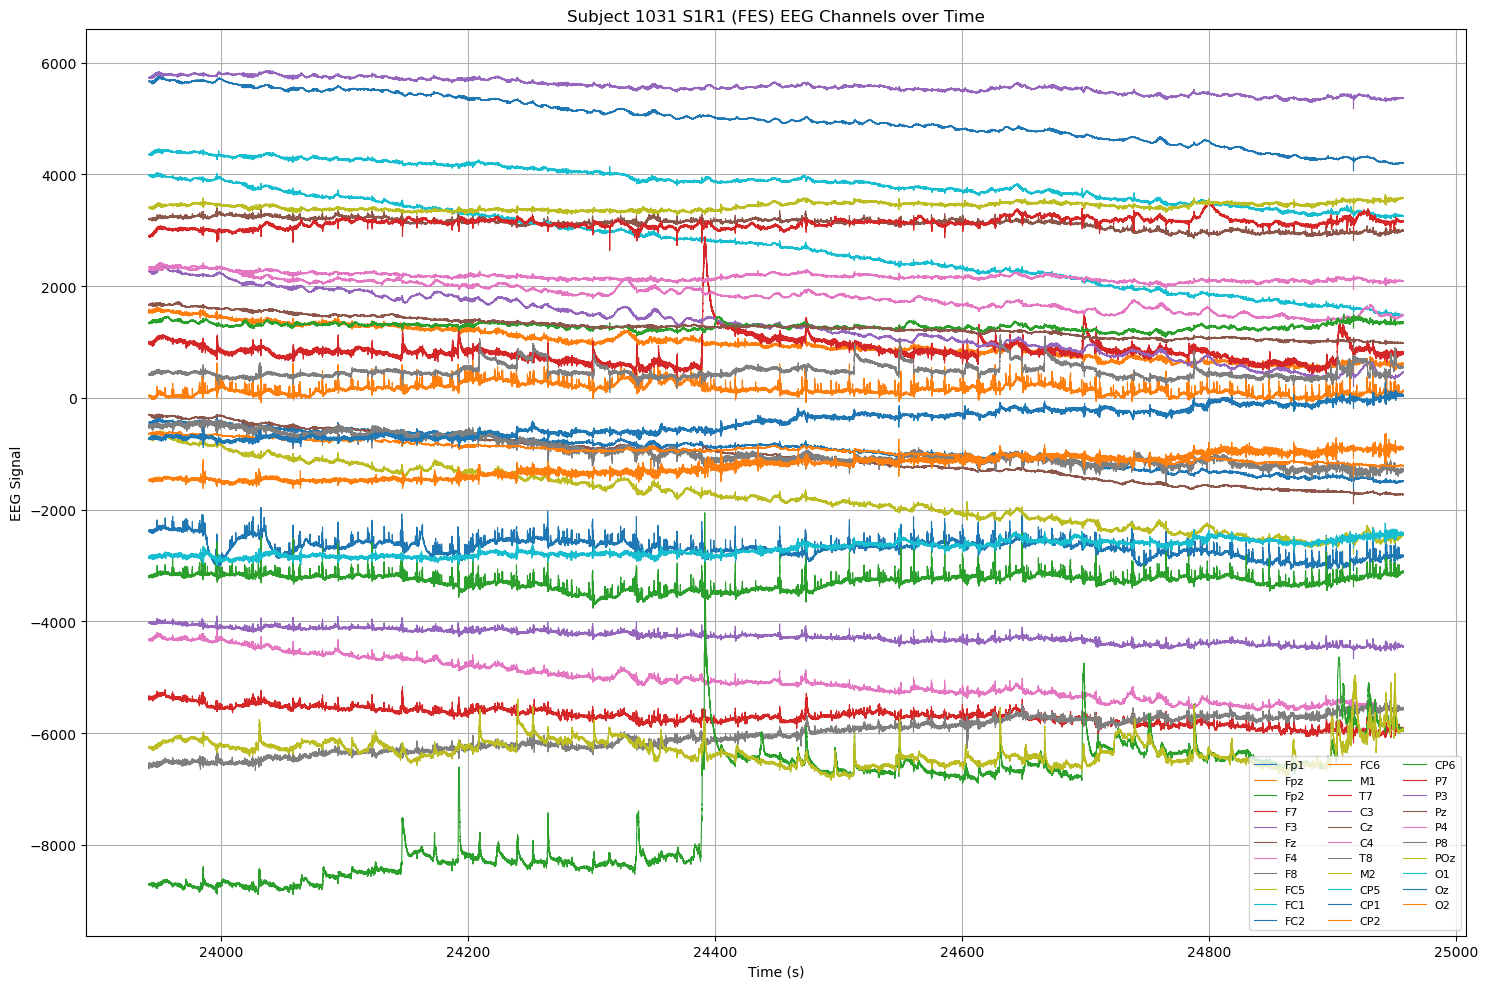

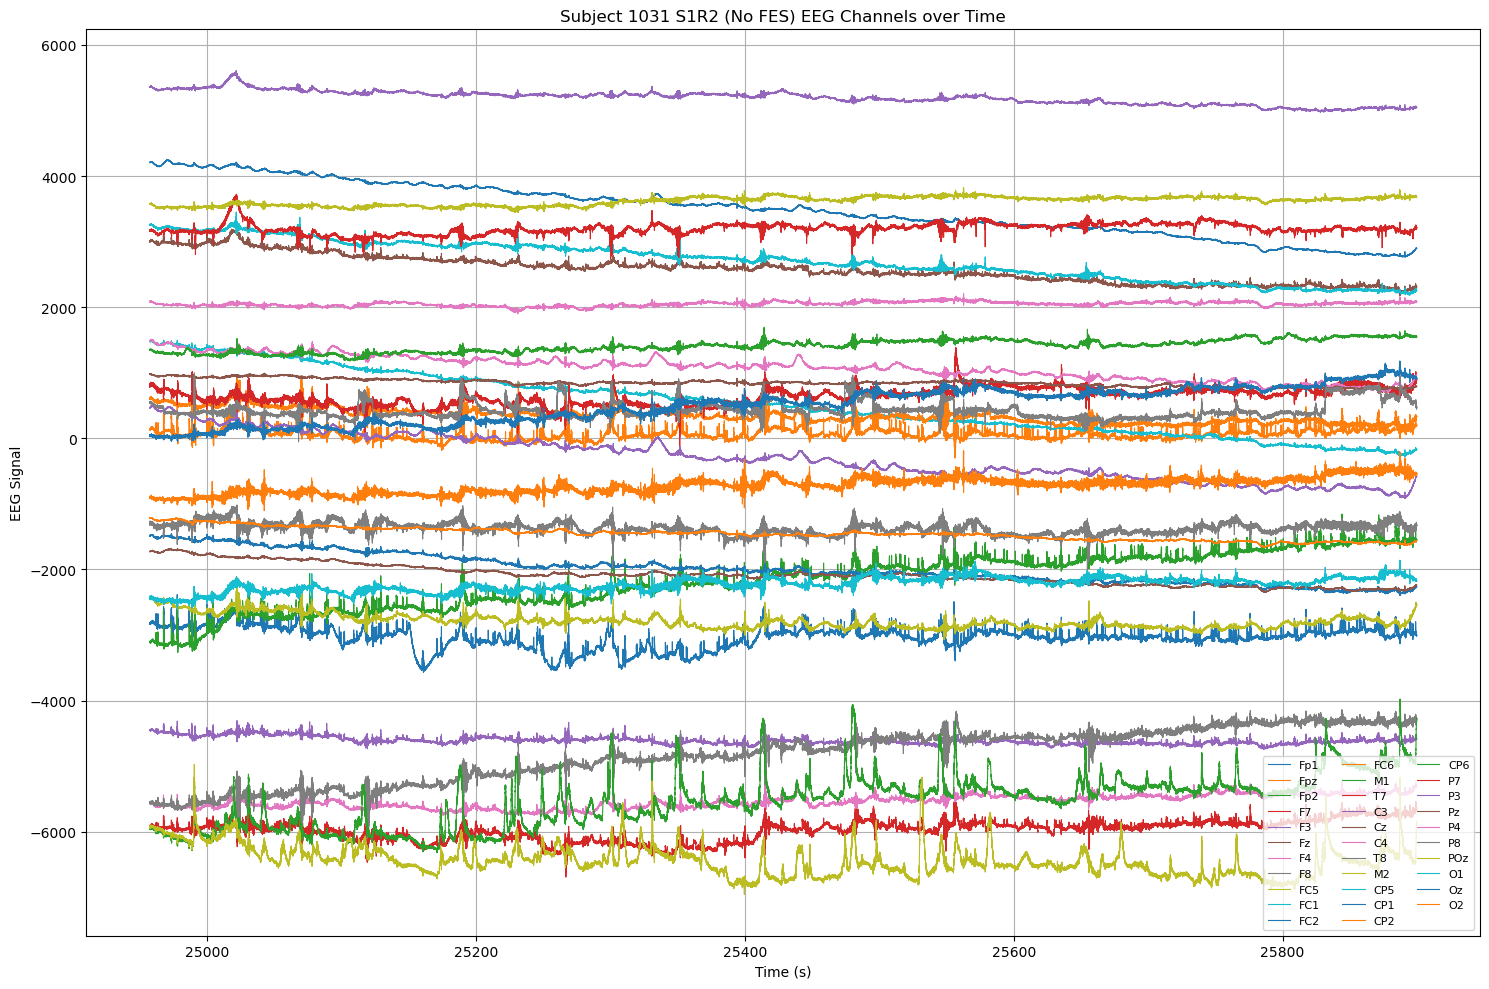

In [11]:
channel_cols = [col for col in subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1031 S1R1 (FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

channel_cols = [col for col in subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1031 S1R2 (No FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

# channel_cols = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1031 S1R1 (FES) EEG Channels over Time (Trials)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1031 S1R2 (No FES) EEG Channels over Time (Trials)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1031 S1R1 (FES) EEG Channels over Time (Robot)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1031 S1R2 (No FES) EEG Channels over Time (Robot)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

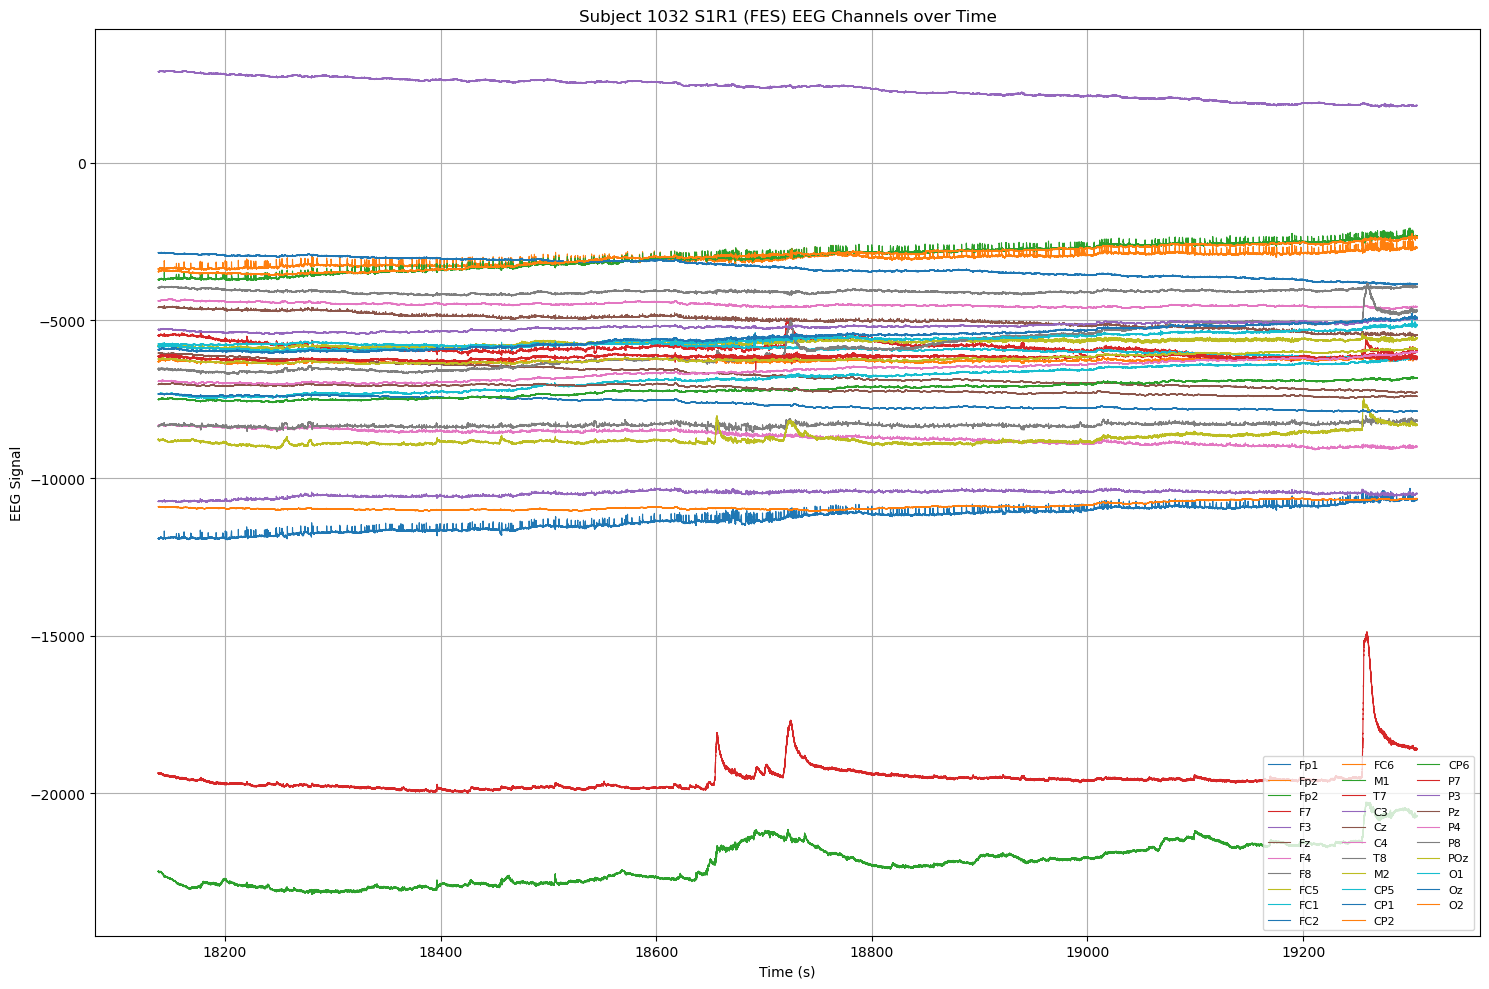

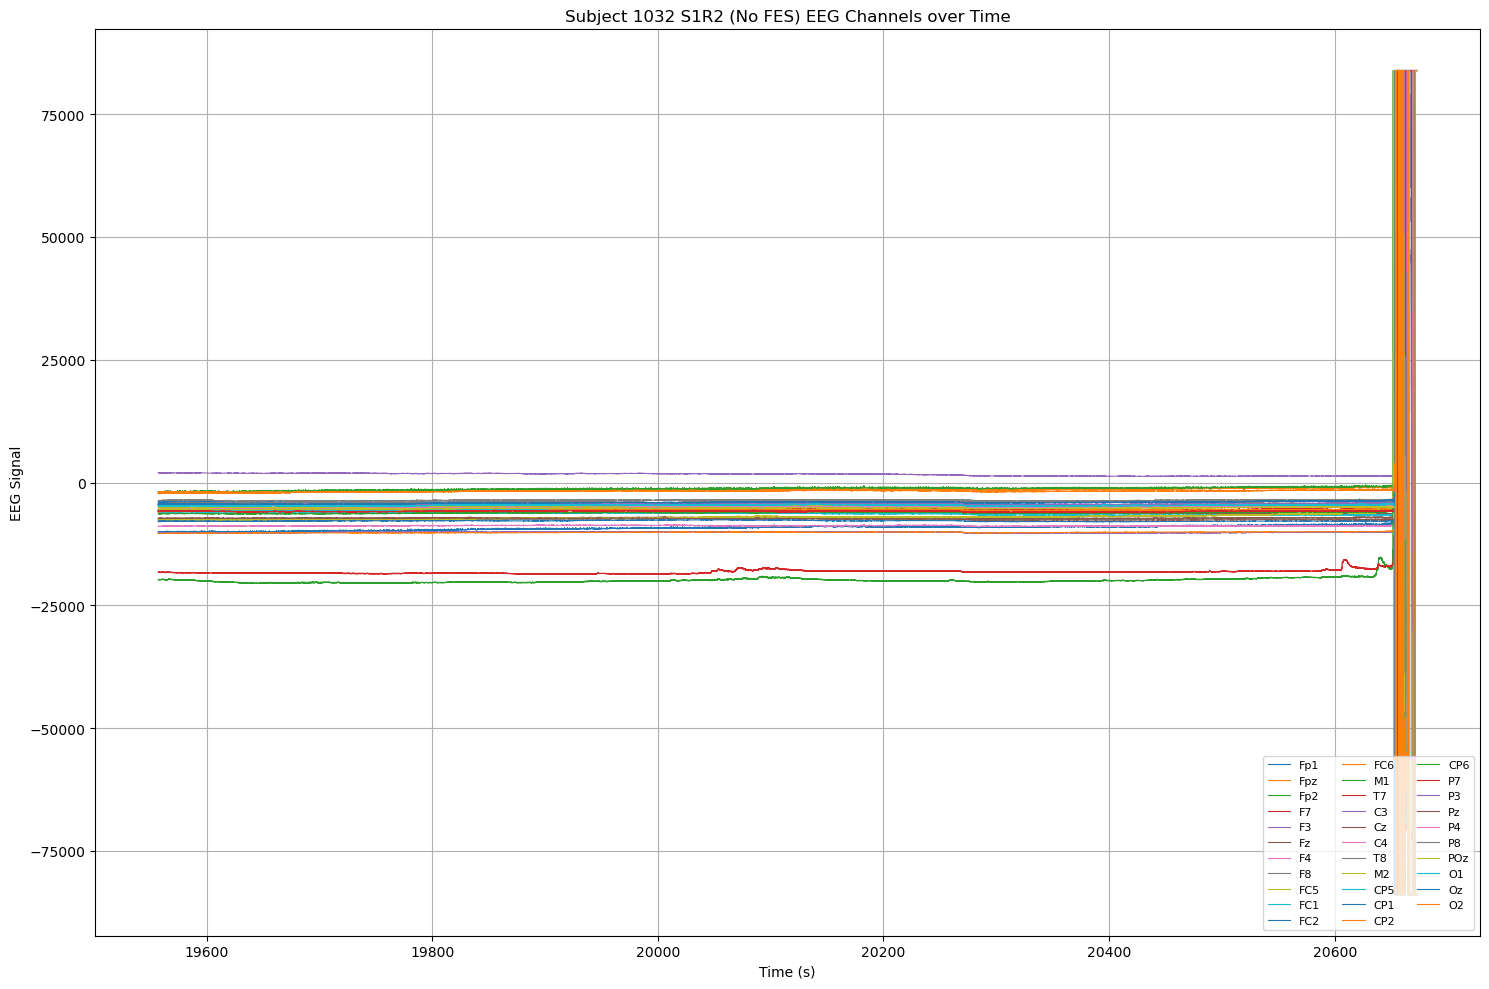

In [12]:
channel_cols = [col for col in subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1032 S1R1 (FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

channel_cols = [col for col in subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1032 S1R2 (No FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

# channel_cols = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1032 S1R1 (FES) EEG Channels over Time (Trials)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1032 S1R2 (No FES) EEG Channels over Time (Trials)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1032 S1R1 (FES) EEG Channels over Time (Robot)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1032 S1R2 (No FES) EEG Channels over Time (Robot)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

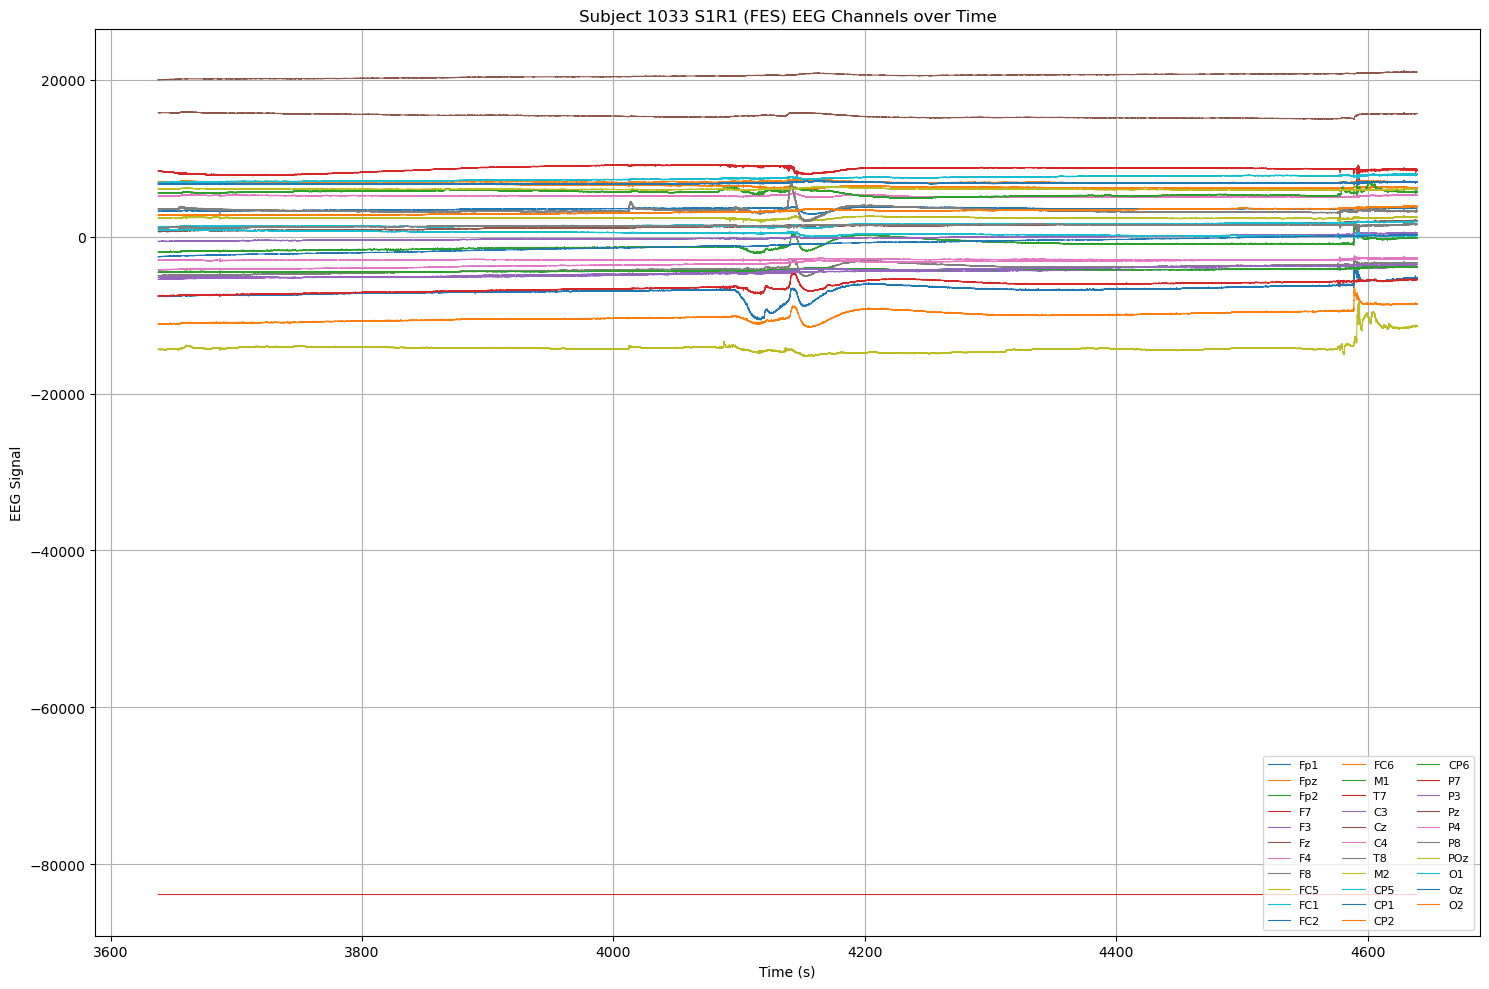

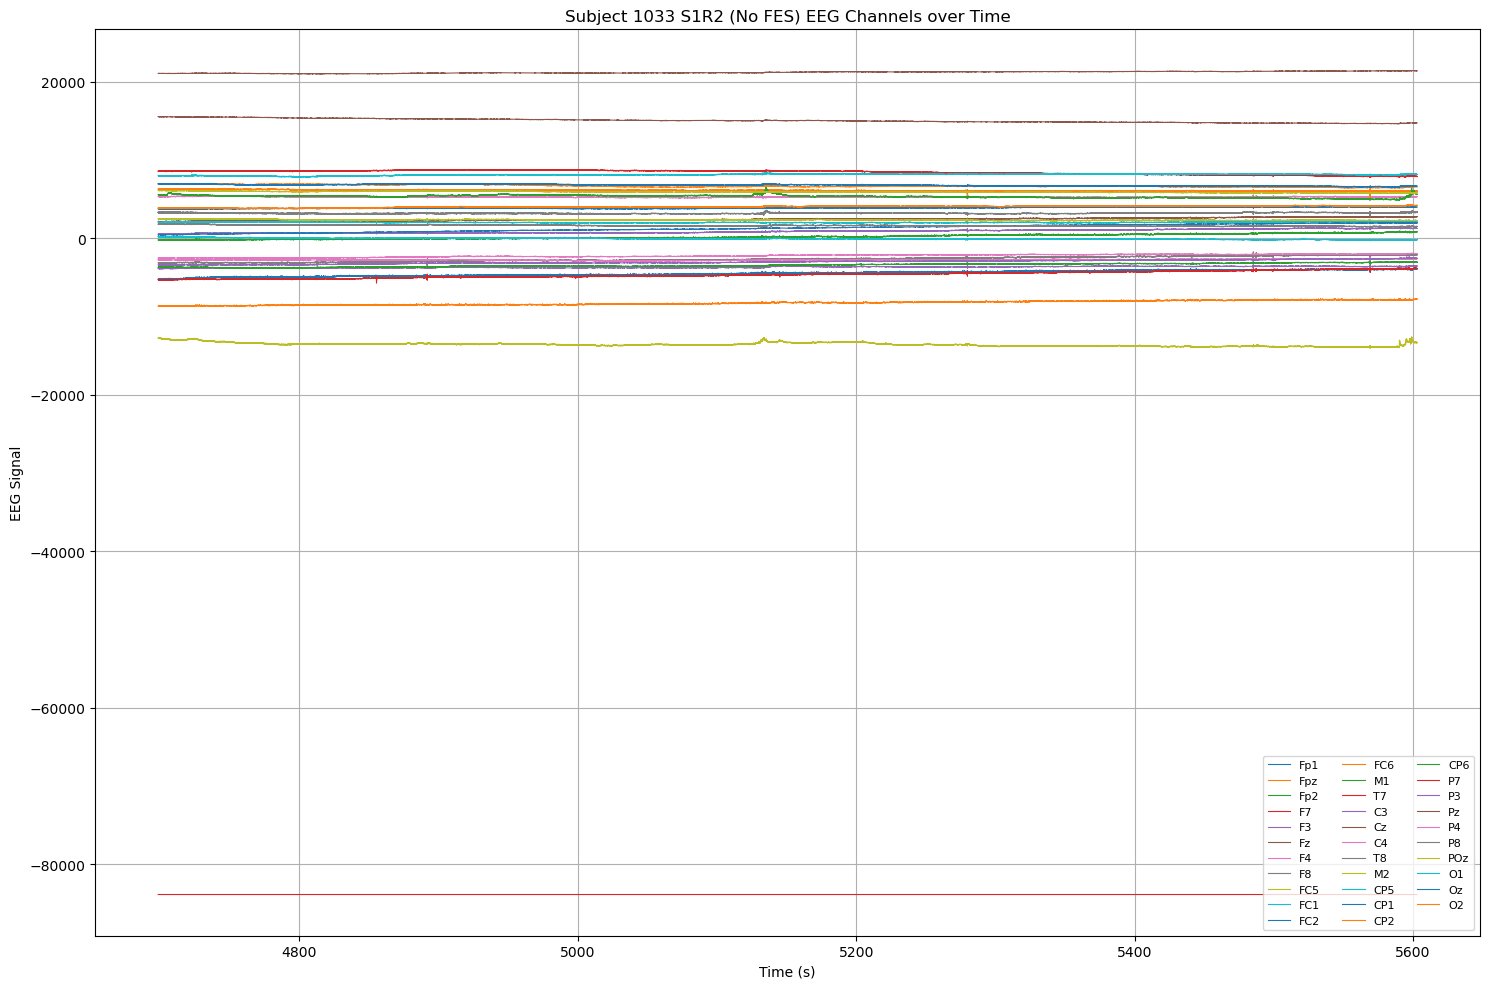

In [13]:
channel_cols = [col for col in subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1033 S1R1 (FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

channel_cols = [col for col in subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# Plot
plt.figure(figsize=(15, 10))
for ch in channel_cols:
    plt.plot(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('Subject 1033 S1R2 (No FES) EEG Channels over Time')
plt.legend(loc='lower right', ncol=3, fontsize=8)
plt.tight_layout()
plt.grid(True)
plt.show()

# channel_cols = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1033 S1R1 (FES) EEG Channels over Time (Trials)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1033 S1R2 (No FES) EEG Channels over Time (Trials)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Time'], subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1033 S1R1 (FES) EEG Channels over Time (Robot)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

# channel_cols = [col for col in subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# # Plot
# plt.figure(figsize=(15, 10))
# for ch in channel_cols:
#     plt.plot(subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Time'], subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], label=ch, linewidth=0.8)

# plt.xlabel('Time (s)')
# plt.ylabel('EEG Signal')
# plt.title('Subject 1033 S1R2 (No FES) EEG Channels over Time (Robot)')
# plt.legend(loc='lower right', ncol=3, fontsize=8)
# plt.tight_layout()
# plt.grid(True)
# plt.show()

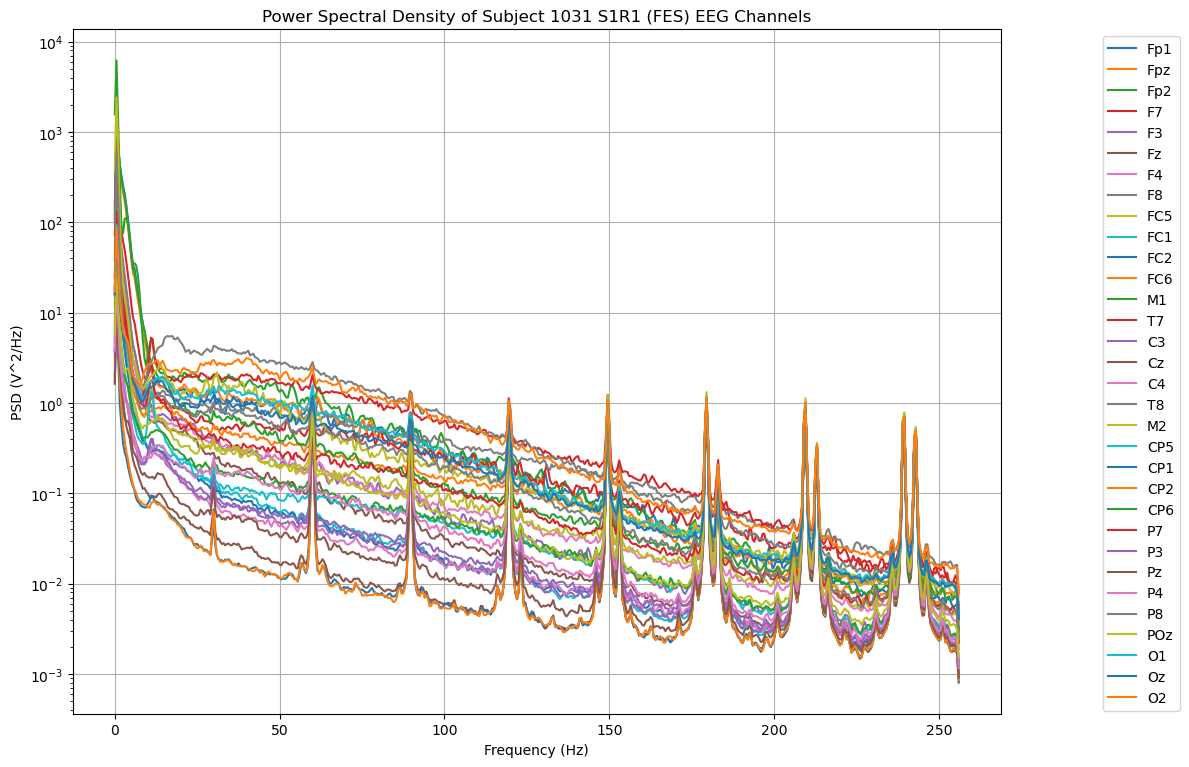

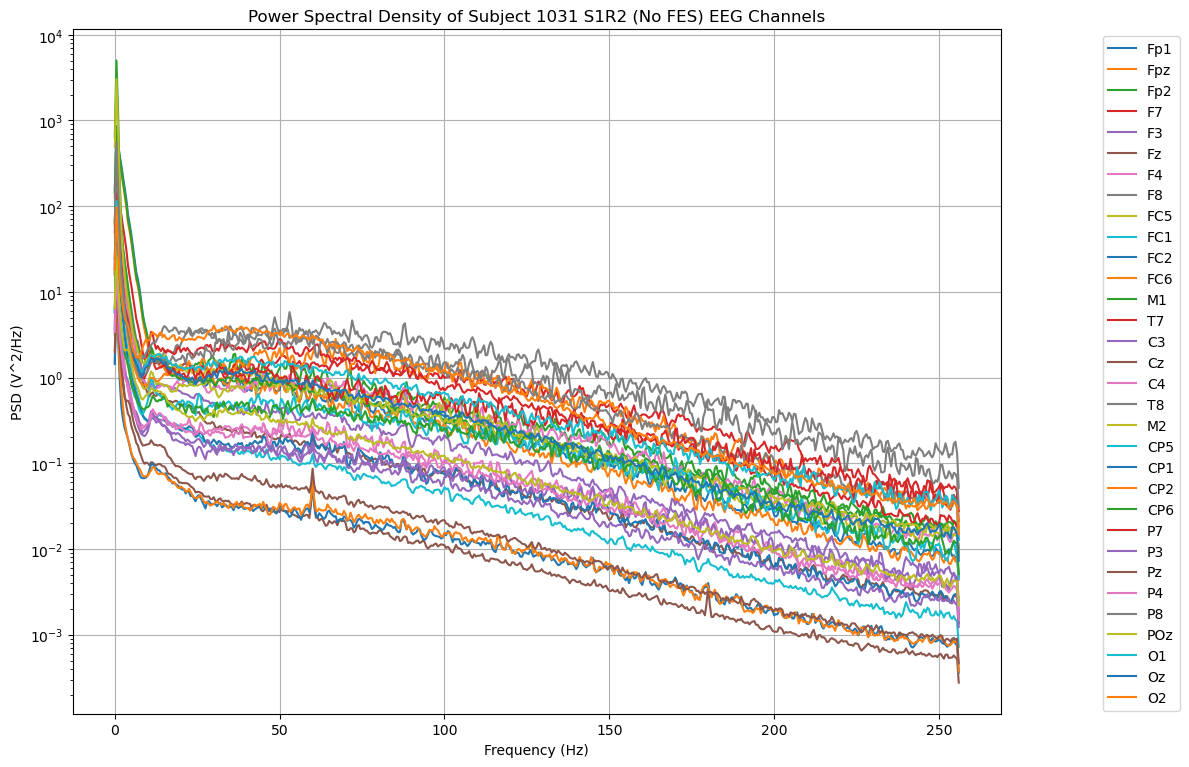

In [14]:
eeg_channels = [col for col in subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1031 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1031 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R1 (FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R2 (No FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R1 (FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R2 (No FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

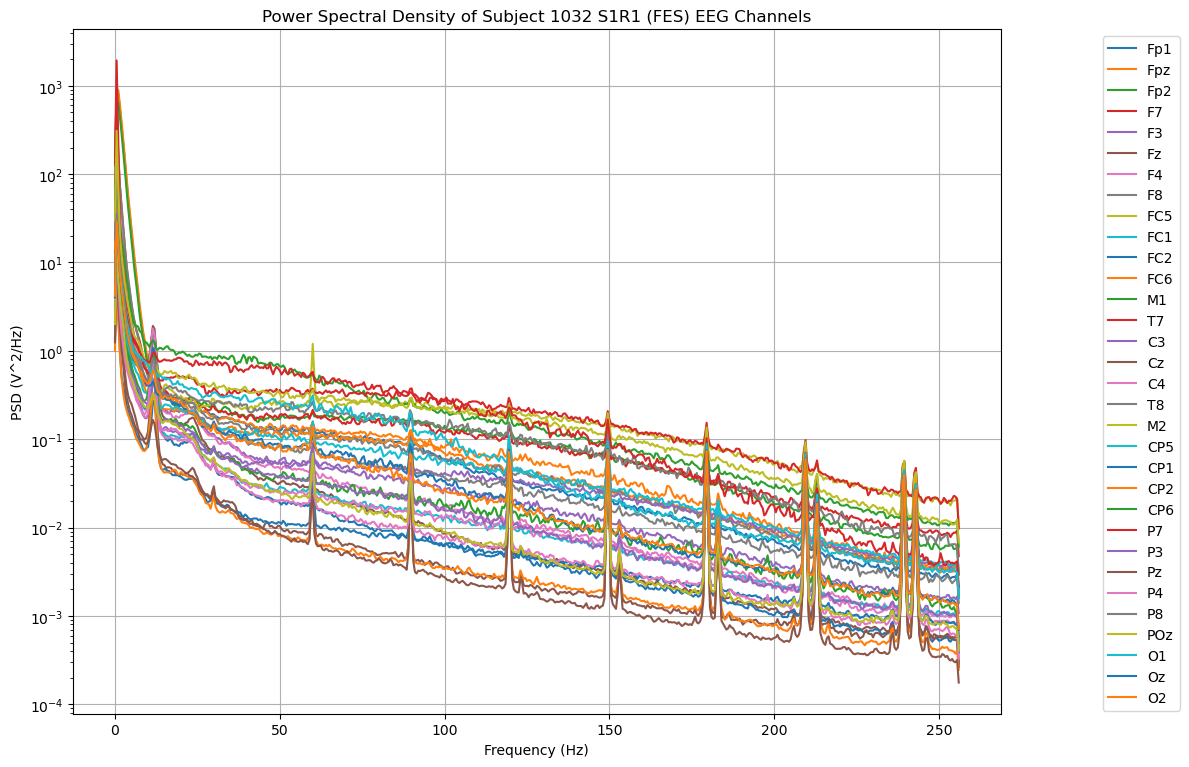

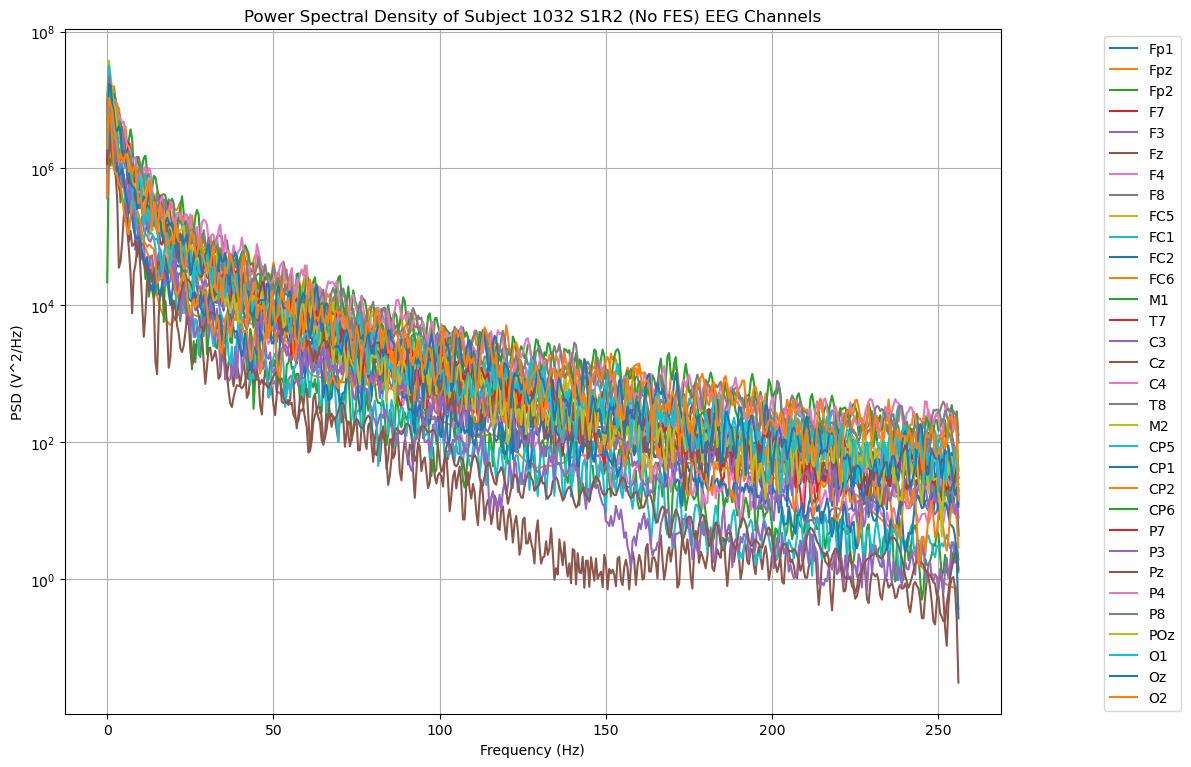

In [15]:
eeg_channels = [col for col in subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1032 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1032 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R1 (FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R2 (No FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R1 (FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R2 (No FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

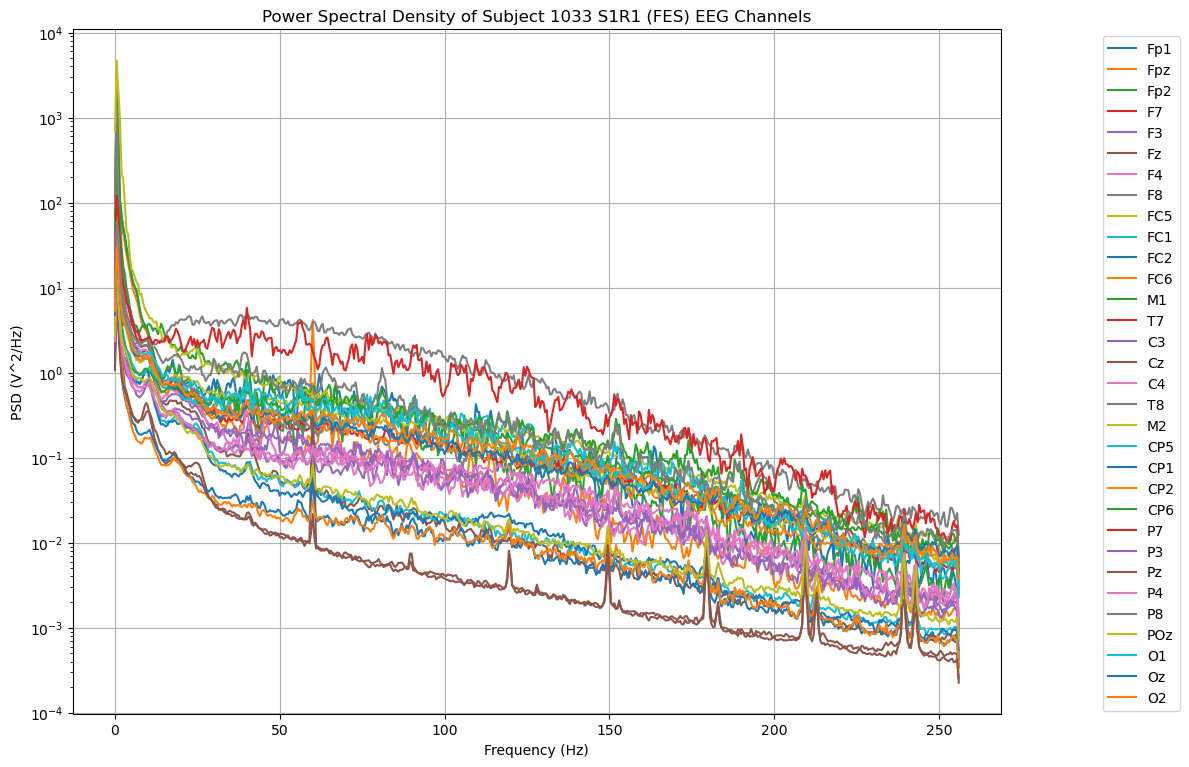

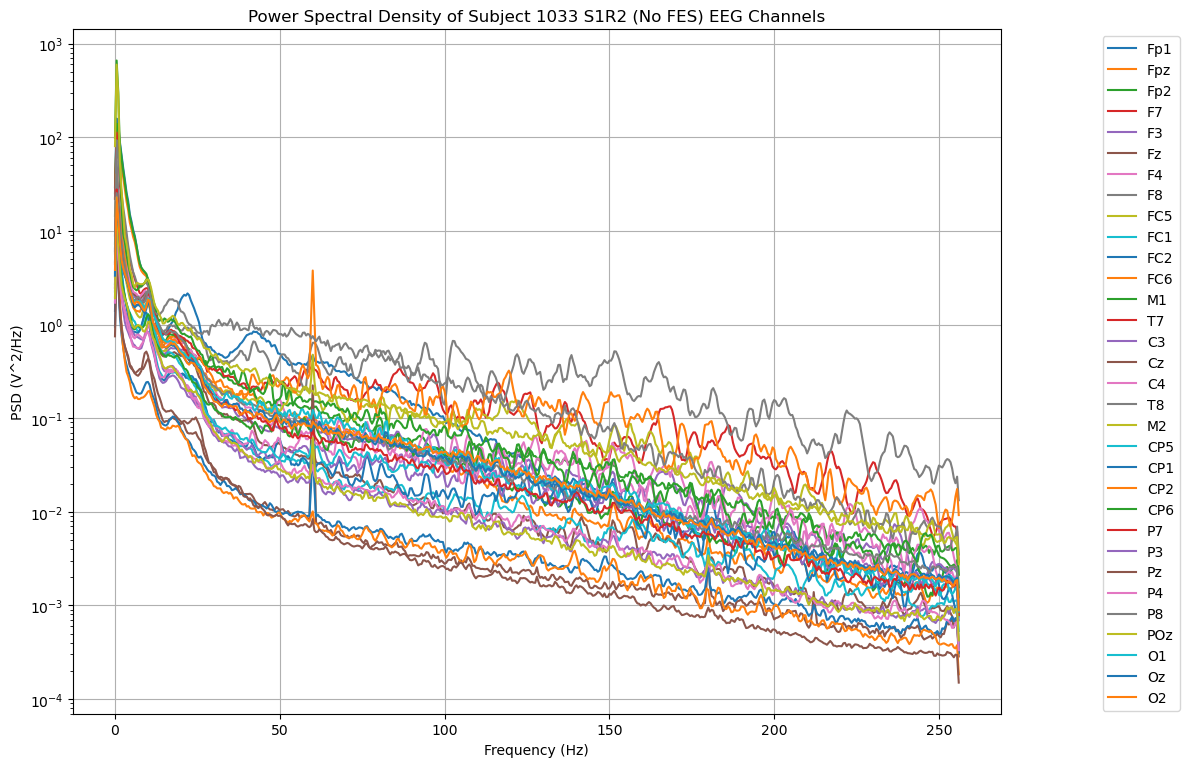

In [16]:
eeg_channels = [col for col in subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1033 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1033 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R1 (FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R2 (No FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R1 (FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R2 (No FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Creating RawArray with float64 data, n_channels=32, n_times=519854
    Range : 0 ... 519853 =      0.000 ...  1015.338 secs
Ready.
Effective window size : 4.000 (s)


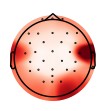

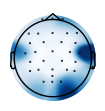

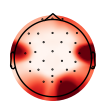

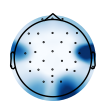

(<matplotlib.image.AxesImage at 0x21982309310>, None)

In [17]:
channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

sfreq = fs
df_eeg = subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0].drop(columns=['FES', 'HIT', 'Outcome', 'Label', 'OutcomeClass', 'Trial'])
data = df_eeg[channels].values.T  # Transpose to (channels, time points)
info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(data, info)
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

psds, freqs = mne.time_frequency.psd_array_welch(
    raw.get_data(),  # Input the data from RawArray
    sfreq=sfreq,     # Sampling frequency
    fmin=1,          # Lower frequency bound
    fmax=50,         # Upper frequency bound
    n_fft=2048,      # FFT length
    average='mean'   # Averaging method
)

f15_idx = np.argmin(np.abs(freqs - 15))
f30_idx = np.argmin(np.abs(freqs - 30))
f45_idx = np.argmin(np.abs(freqs - 45))
f60_idx = np.argmin(np.abs(freqs - 60))

psd_15hz = psds[:, f15_idx]
psd_30hz = psds[:, f30_idx]
psd_45hz = psds[:, f45_idx]
psd_60hz = psds[:, f60_idx]


mne.viz.plot_topomap(psd_15hz, raw.info, cmap='Reds', contours=0, show=True, sphere=0.1, vlim=(None, None))
mne.viz.plot_topomap(psd_30hz, raw.info, cmap='Blues', contours=0, show=True, sphere=0.1, vlim=(None, None))
mne.viz.plot_topomap(psd_45hz, raw.info, cmap='Reds', contours=0, show=True, sphere=0.1, vlim=(None, None))
mne.viz.plot_topomap(psd_60hz, raw.info, cmap='Blues', contours=0, show=True, sphere=0.1, vlim=(None, None))


Filter ranges from paper: https://www.ncbi.nlm.nih.gov/books/NBK539805/
Delta (0.5-3.5 Hz): Slowest waves, primarily associated with deep sleep and coma.
Theta (4-7.5 Hz): Intermediate waves, linked to sleep, relaxation, and creativity.
Alpha (8-12 Hz): Moderate waves, often present during relaxation, meditation, and drowsiness.
Beta (13-30 Hz): Fastest waves, associated with wakefulness, alertness, and active concentration.
High-Frequency Oscillations (HFOs) (greater than 30Hz): sensory perception integrating different areas. Especially prominent in epilepsy
Noise at 60 -> power line and there is some noise at 30Hz harmonic

So, 1-33 Hz (room to catch freqs a little outside + 2 Hz res; not worried ab missing 0.5-1 since we're not really looking for deep sleep signals) bandpass with notch at 30, 15(?)

In [18]:
def filter_channels(df, lowpass, highpass, fs, notch_freqs=None):
    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)

    def notch_filter(data, freq, fs, quality=30):
        nyquist = 0.5 * fs
        w0 = freq / nyquist
        b, a = iirnotch(w0, quality)
        return filtfilt(b, a, data)

    # Include EEG and AUX channels (update this as needed)
    eeg_channels = [col for col in channels]

    for ch in eeg_channels:
        signal = df[ch]
        signal = bandpass_filter(signal, lowpass, highpass, fs)
        if notch_freqs:
            for notch in notch_freqs:
                signal = notch_filter(signal, notch, fs)
        df[ch] = signal

    return df


In [19]:
subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0] = filter_channels(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1] = filter_channels(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1], 1, 32, fs, [15, 30])
subjects['Subj1031']['Online']['Sessions'][1]['Runs'][0] = filter_channels(subjects['Subj1031']['Online']['Sessions'][1]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1031']['Online']['Sessions'][1]['Runs'][1] = filter_channels(subjects['Subj1031']['Online']['Sessions'][1]['Runs'][1], 1, 32, fs, [15, 30])
subjects['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = filter_channels(subjects['Subj1031']['Offline']['Sessions'][0]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1031']['Offline']['Sessions'][1]['Runs'][0] = filter_channels(subjects['Subj1031']['Offline']['Sessions'][1]['Runs'][0], 1, 32, fs, [15, 30])

In [20]:
subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0] = filter_channels(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1] = filter_channels(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1], 1, 32, fs, [15, 30])
subjects['Subj1032']['Online']['Sessions'][1]['Runs'][0] = filter_channels(subjects['Subj1032']['Online']['Sessions'][1]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1032']['Online']['Sessions'][1]['Runs'][1] = filter_channels(subjects['Subj1032']['Online']['Sessions'][1]['Runs'][1], 1, 32, fs, [15, 30])
subjects['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = filter_channels(subjects['Subj1032']['Offline']['Sessions'][0]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1032']['Offline']['Sessions'][1]['Runs'][0] = filter_channels(subjects['Subj1032']['Offline']['Sessions'][1]['Runs'][0], 1, 32, fs, [15, 30])

In [21]:
subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0] = filter_channels(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1] = filter_channels(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1], 1, 32, fs, [15, 30])
subjects['Subj1033']['Online']['Sessions'][1]['Runs'][0] = filter_channels(subjects['Subj1033']['Online']['Sessions'][1]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1033']['Online']['Sessions'][1]['Runs'][1] = filter_channels(subjects['Subj1033']['Online']['Sessions'][1]['Runs'][1], 1, 32, fs, [15, 30])
subjects['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = filter_channels(subjects['Subj1033']['Offline']['Sessions'][0]['Runs'][0], 1, 32, fs, [15, 30])
subjects['Subj1033']['Offline']['Sessions'][1]['Runs'][0] = filter_channels(subjects['Subj1033']['Offline']['Sessions'][1]['Runs'][0], 1, 32, fs, [15, 30])

In [22]:
subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0].head()

Time       Fp1       Fpz       Fp2        F7        F3  \
54203  3637.938379 -0.341106 -1.878646 -2.489657 -0.136788  0.416093   
54204  3637.940333 -0.579490 -3.011805 -4.243804 -0.849495 -0.233102   
54205  3637.942286 -0.860147 -4.040731 -5.848415 -1.534506 -0.812367   
54206  3637.944239 -1.206656 -4.890384 -7.196269 -2.131269 -1.251446   
54207  3637.946192 -1.642343 -5.515946 -8.215385 -2.603345 -1.509347   

             Fz        F4        F8       FC5       FC1       FC2       FC6  \
54203 -1.821316 -2.562091 -2.071640  0.137785 -0.975422 -1.495159 -2.258538   
54204 -2.262637 -3.482088 -3.366793 -0.784471 -1.878154 -1.683874 -2.265280   
54205 -2.664106 -4.330033 -4.609509 -1.660728 -2.685501 -1.840899 -2.282204   
54206 -3.006944 -5.058973 -5.760809 -2.420754 -3.315134 -1.956237 -2.337788   
54207 -3.288212 -5.642300 -6.793749 -3.013074 -3.709487 -2.029112 -2.452647   

             M1        T7        C3        Cz        C4        T8        M2  \
54203 -1.196247  0.000068 -0.587210 -0.653633 -1.084897 -1.062788 -1.778842   
54204 -2.097948  0.000070 -1.606009 -0.750159 -1.115279 -1.939974 -0.382189   
54205 -2.947391  0.000072 -2.560352 -0.806798 -1.182248 -2.837505  0.857834   
54206 -3.676385  0.000074 -3.383676 -0.804410 -1.325949 -3.801518  1.813476   
54207 -4.245342  0.000076 -4.025092 -0.730689 -1.575619 -4.858670  2.382890   

             CP5       CP1       CP2       CP6        P7        P3        Pz  \
54203  -1.397615 -0.234696  0.243045  3.532118  2.618567 -1.176691 -0.332256   
54204  -3.805849 -0.810929  0.712583  4.766331  1.634922 -3.441896 -0.871639   
54205  -6.118645 -1.350001  1.142092  5.847770  0.702150 -5.604673 -1.409327   
54206  -8.224887 -1.811473  1.493906  6.630306 -0.097784 -7.554816 -1.927617   
54207 -10.034408 -2.161688  1.739911  7.019019 -0.716446 -9.200624 -2.406701   

             P4        P8       POz        O1        Oz        O2 Label  \
54203  0.900706 -1.402830 -0.684515  0.215707 -1.190237 -4.306404   100   
54204  1.288506 -0.652214 -1.722752 -0.087130 -1.667631 -4.256342   100   
54205  1.606280  0.059252 -2.744343 -0.394667 -2.127901 -4.225484   100   
54206  1.790935  0.720683 -3.705790 -0.677479 -2.524014 -4.178007   100   
54207  1.800405  1.311521 -4.566879 -0.916120 -2.821639 -4.089187   100   

      OutcomeClass  Trial   FES   HIT Outcome  
54203   REST_BEGIN      0  True  True     HIT  
54204   REST_BEGIN      0  True  True     HIT  
54205   REST_BEGIN      0  True  True     HIT  
54206   REST_BEGIN      0  True  True     HIT  
54207   REST_BEGIN      0  True  True     HIT

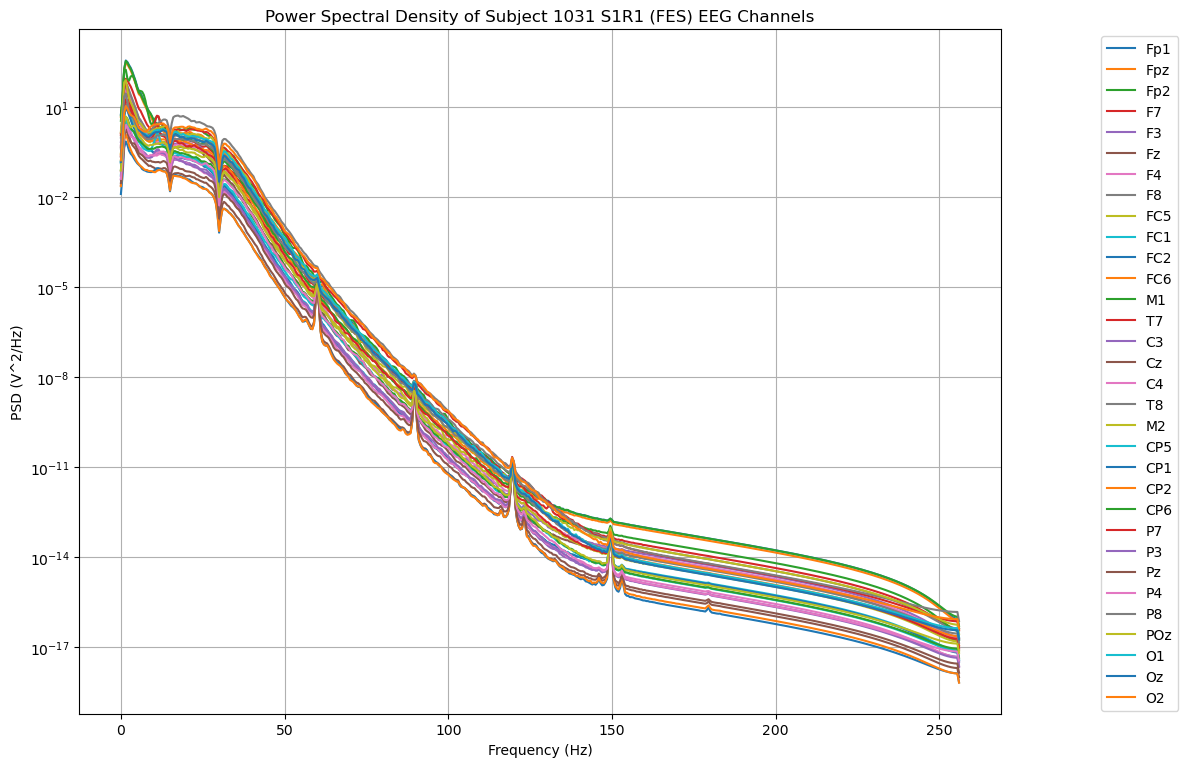

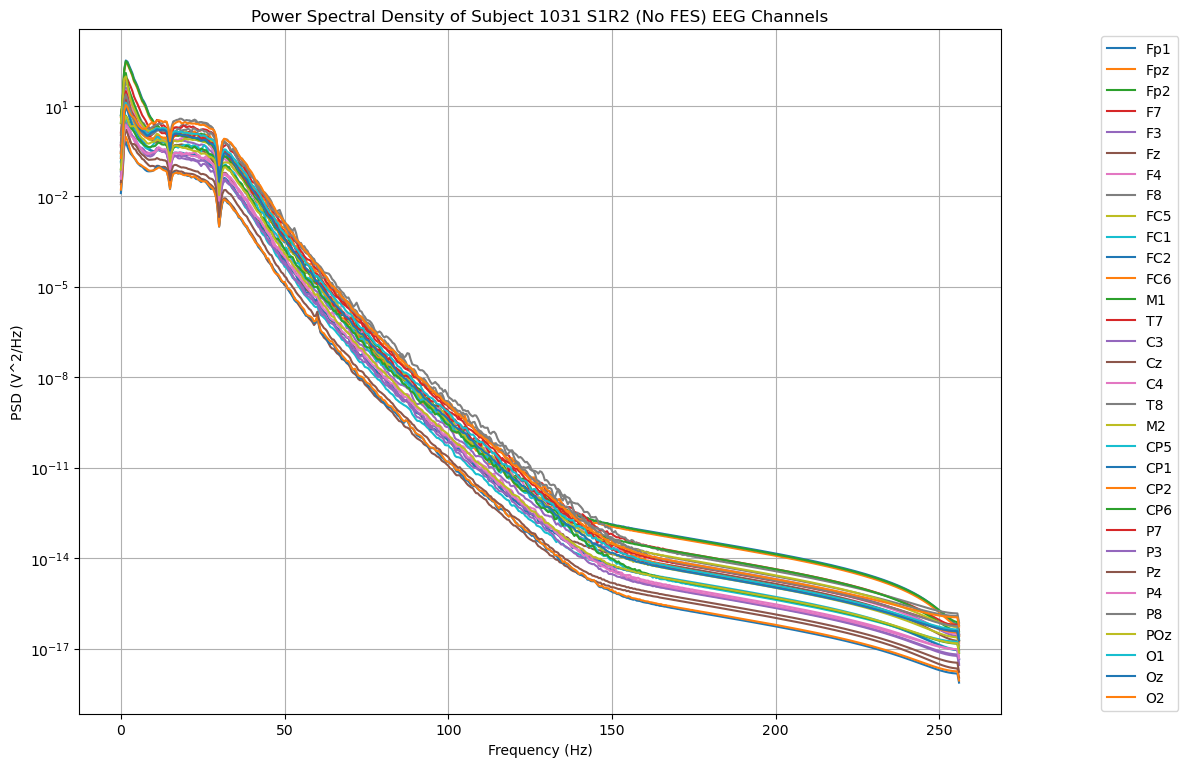

In [23]:
eeg_channels = [col for col in subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1031 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1031 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R1 (FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R2 (No FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R1 (FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1031 S1R2 (No FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

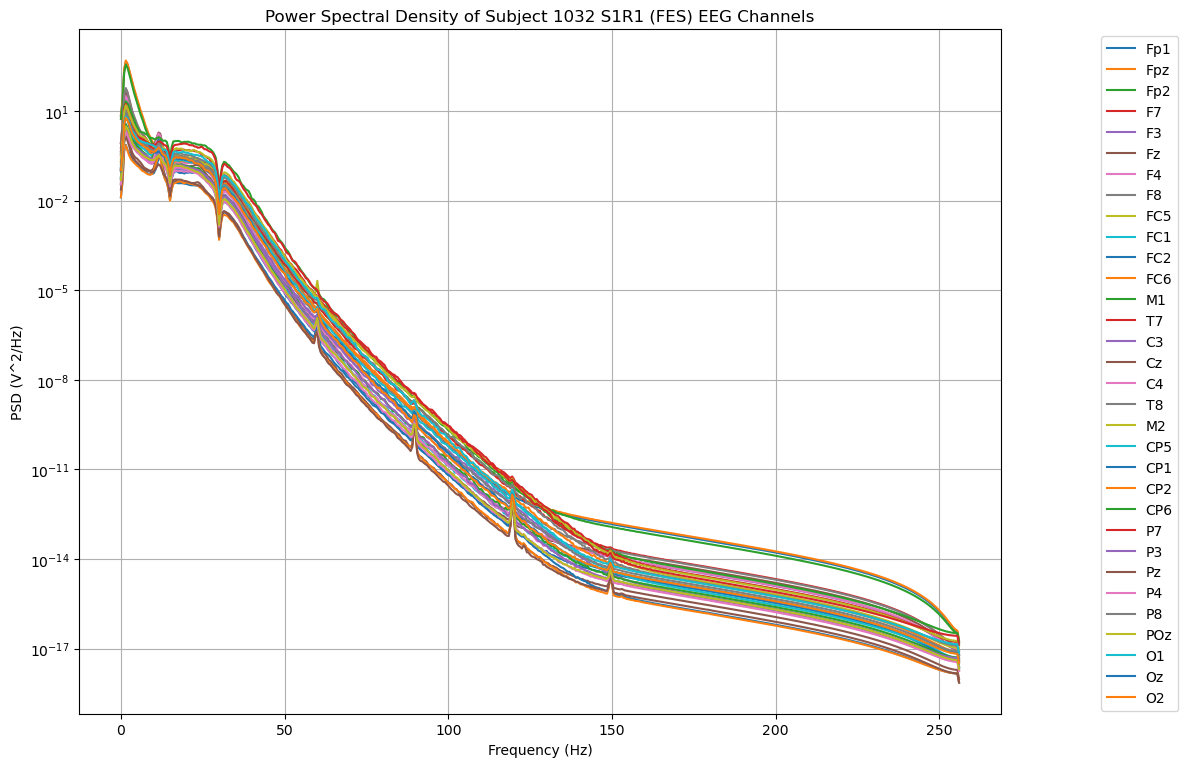

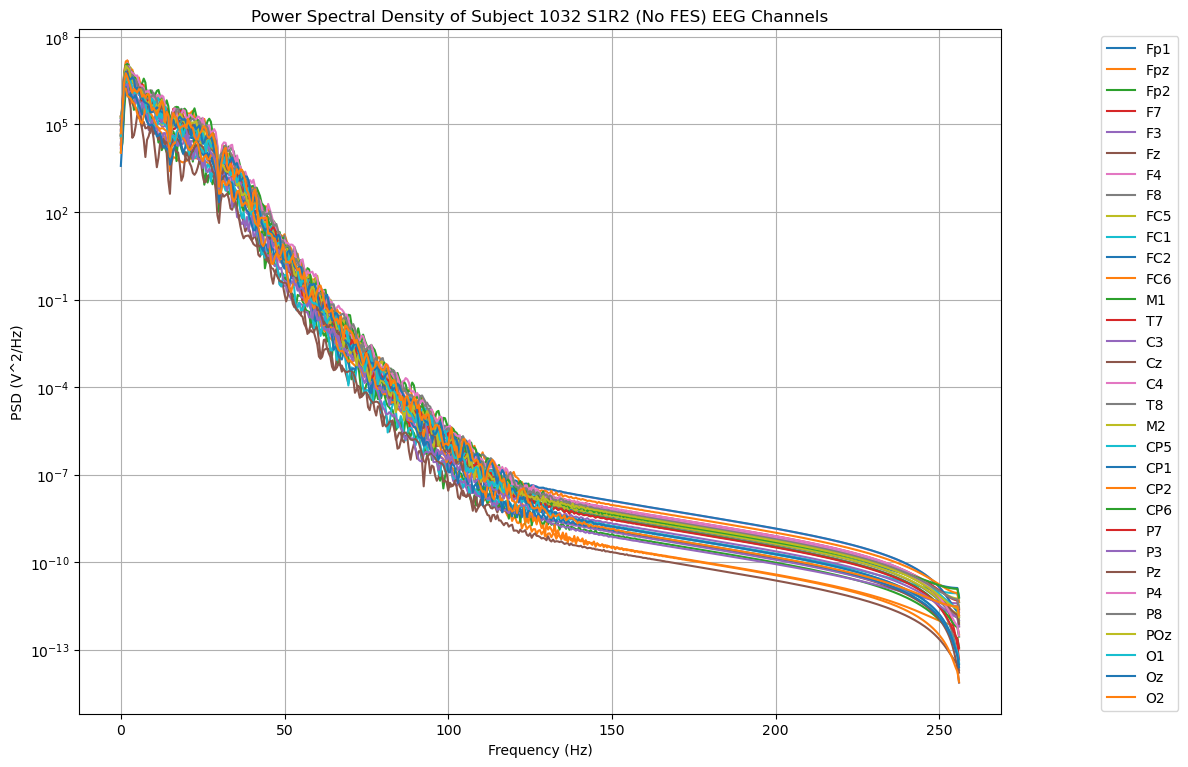

In [24]:
eeg_channels = [col for col in subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1032 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1032 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R1 (FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R2 (No FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R1 (FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1032 S1R2 (No FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

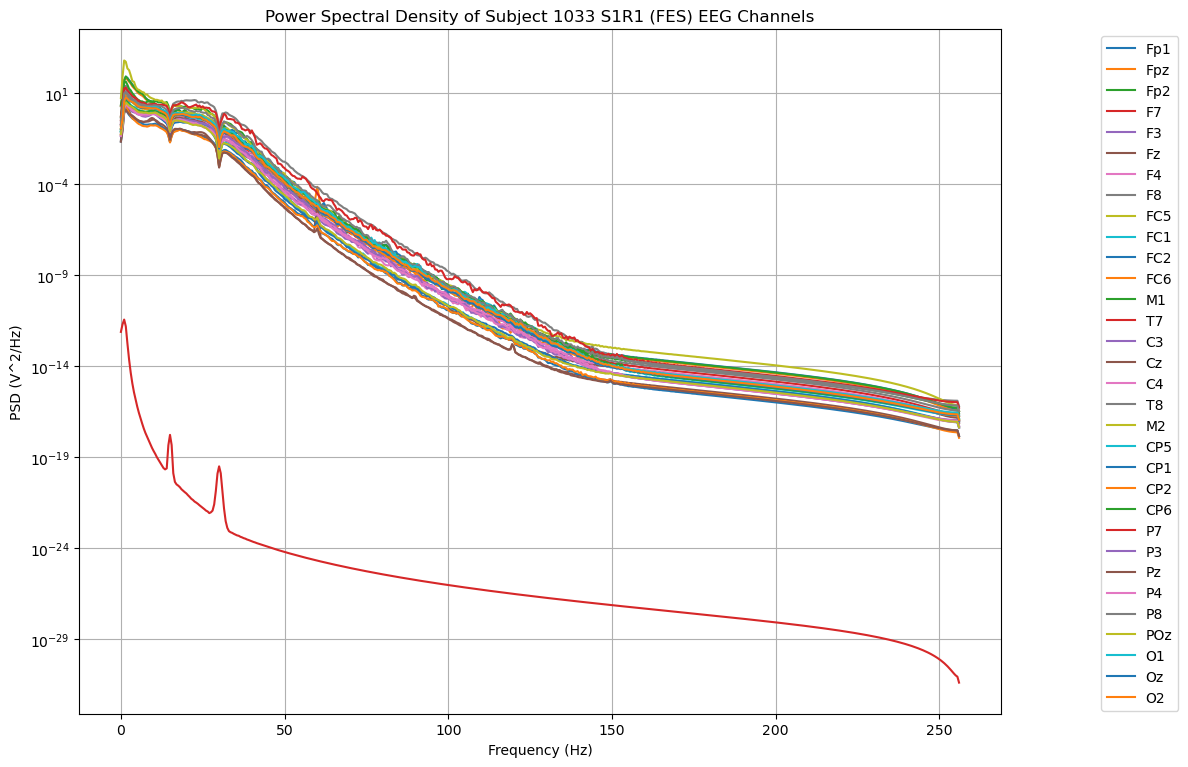

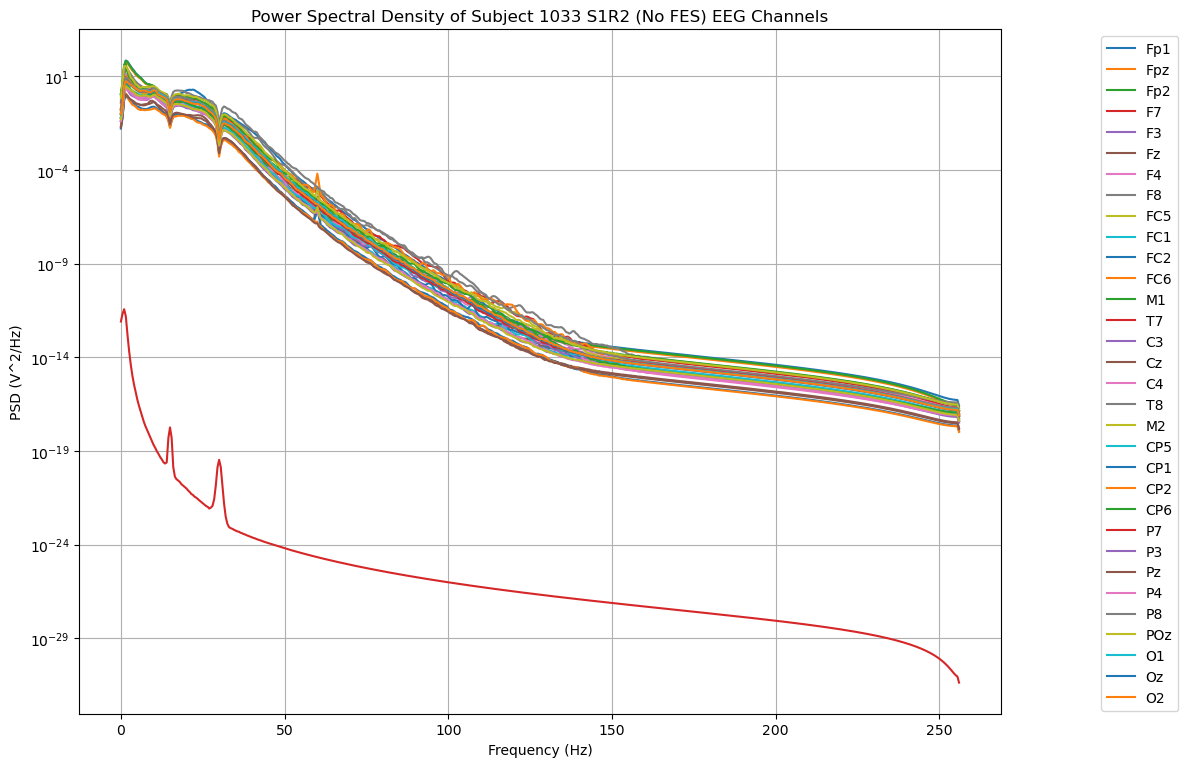

In [25]:
eeg_channels = [col for col in subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1033 S1R1 (FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

eeg_channels = [col for col in subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

plt.figure(figsize=(12, 8))

for ch in eeg_channels:
    f, Pxx = welch(subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
    plt.semilogy(f, Pxx, label=ch)

plt.title('Power Spectral Density of Subject 1033 S1R2 (No FES) EEG Channels')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R1 (FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R2 (No FES) EEG Channels (Trials)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R1 (FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# eeg_channels = [col for col in subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if col in channels]

# plt.figure(figsize=(12, 8))

# for ch in eeg_channels:
#     f, Pxx = welch(subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][ch], fs=fs, nperseg=1024)
#     plt.semilogy(f, Pxx, label=ch)

# plt.title('Power Spectral Density of Subject 1033 S1R2 (No FES) EEG Channels (Robots)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('PSD (V^2/Hz)')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [26]:
subjects_trials_only = copy.deepcopy(subjects)
# just making a copy of subjects to hold only trial data
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1][subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]

subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1][subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]

subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1][subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0][subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(trial_labels)]
subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] = subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0][subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(trial_labels)]

In [27]:
subjects_robots_only = copy.deepcopy(subjects)
# just making a copy of subjects to hold only trial data
subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][0][subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][1][subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = subjects_robots_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0][subjects_robots_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] = subjects_robots_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0][subjects_robots_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]

subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][0][subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][1][subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = subjects_robots_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0][subjects_robots_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] = subjects_robots_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0][subjects_robots_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]

subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][0][subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][1][subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = subjects_robots_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0][subjects_robots_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]
subjects_robots_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] = subjects_robots_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0][subjects_robots_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(robot_miss_labels)]

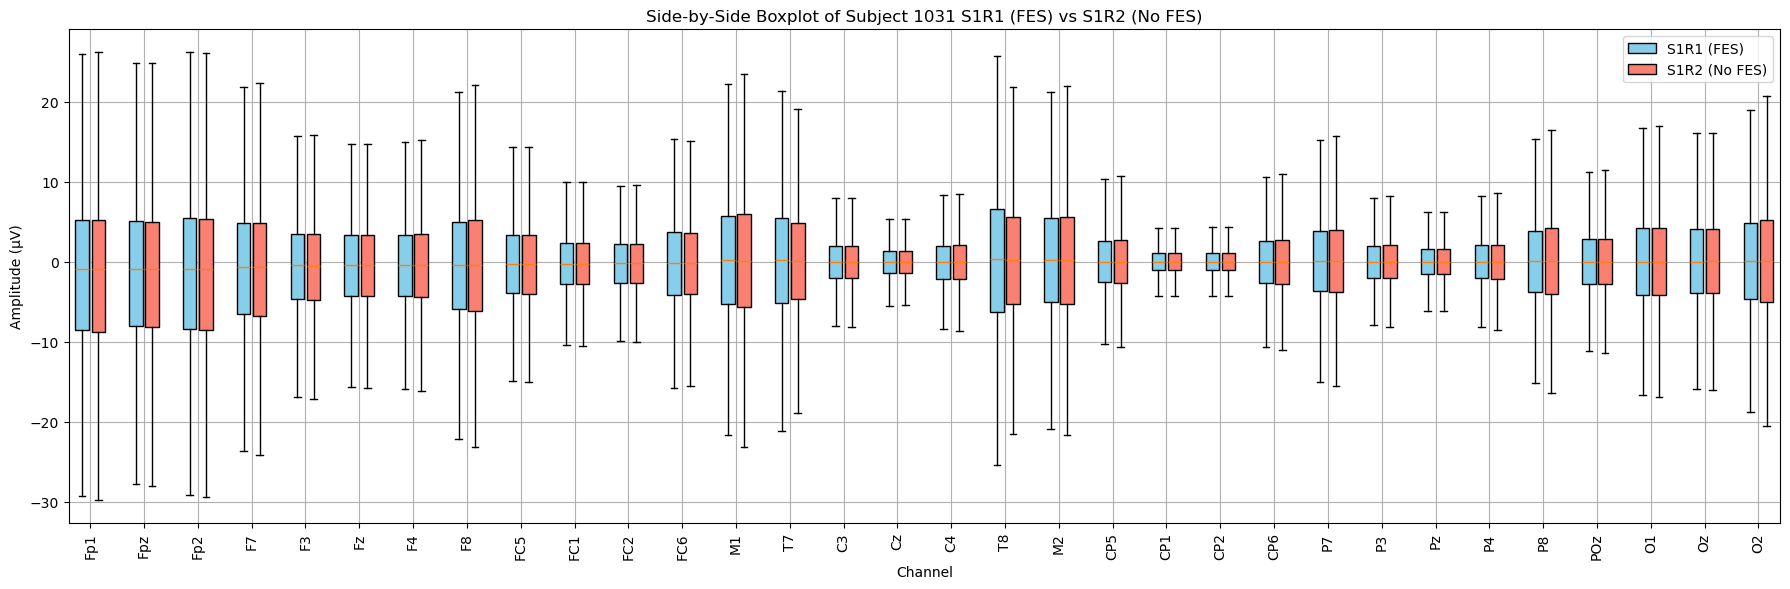

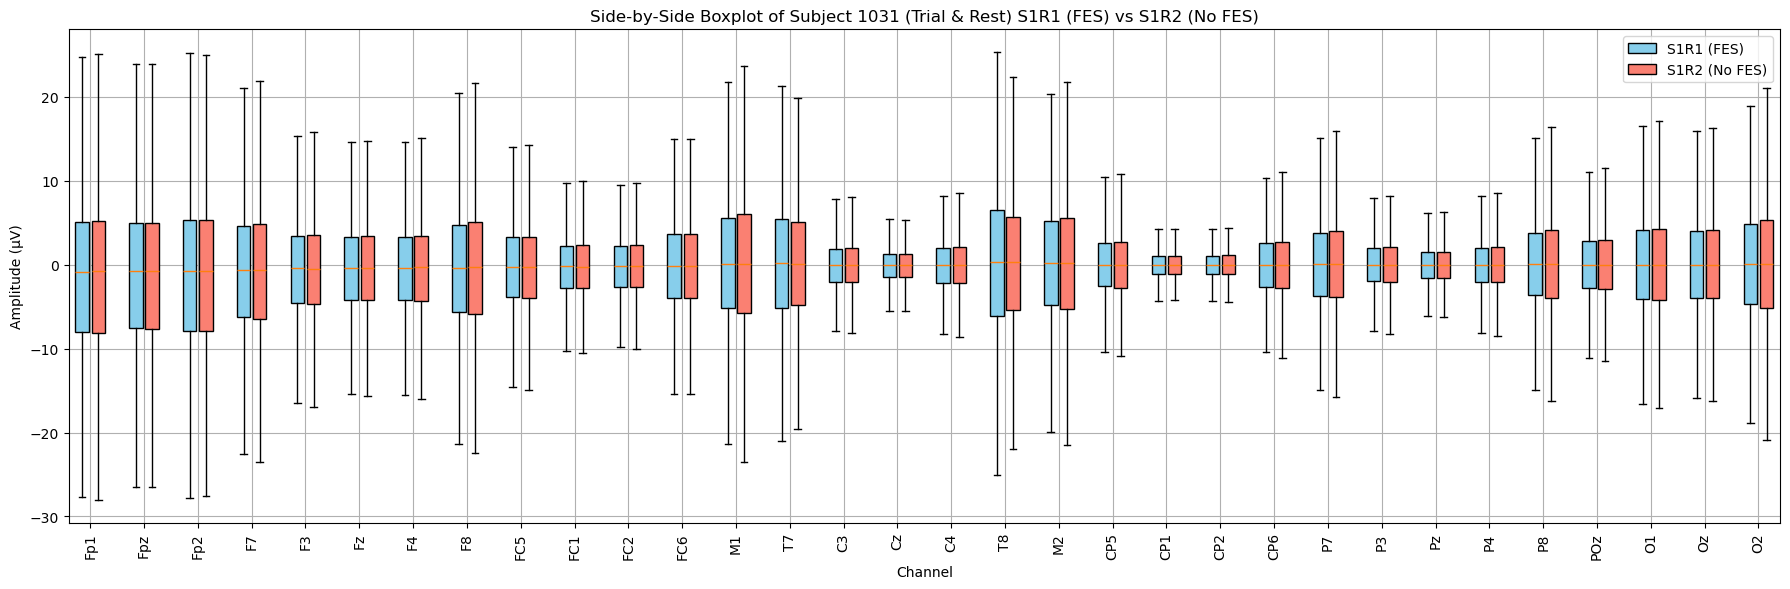

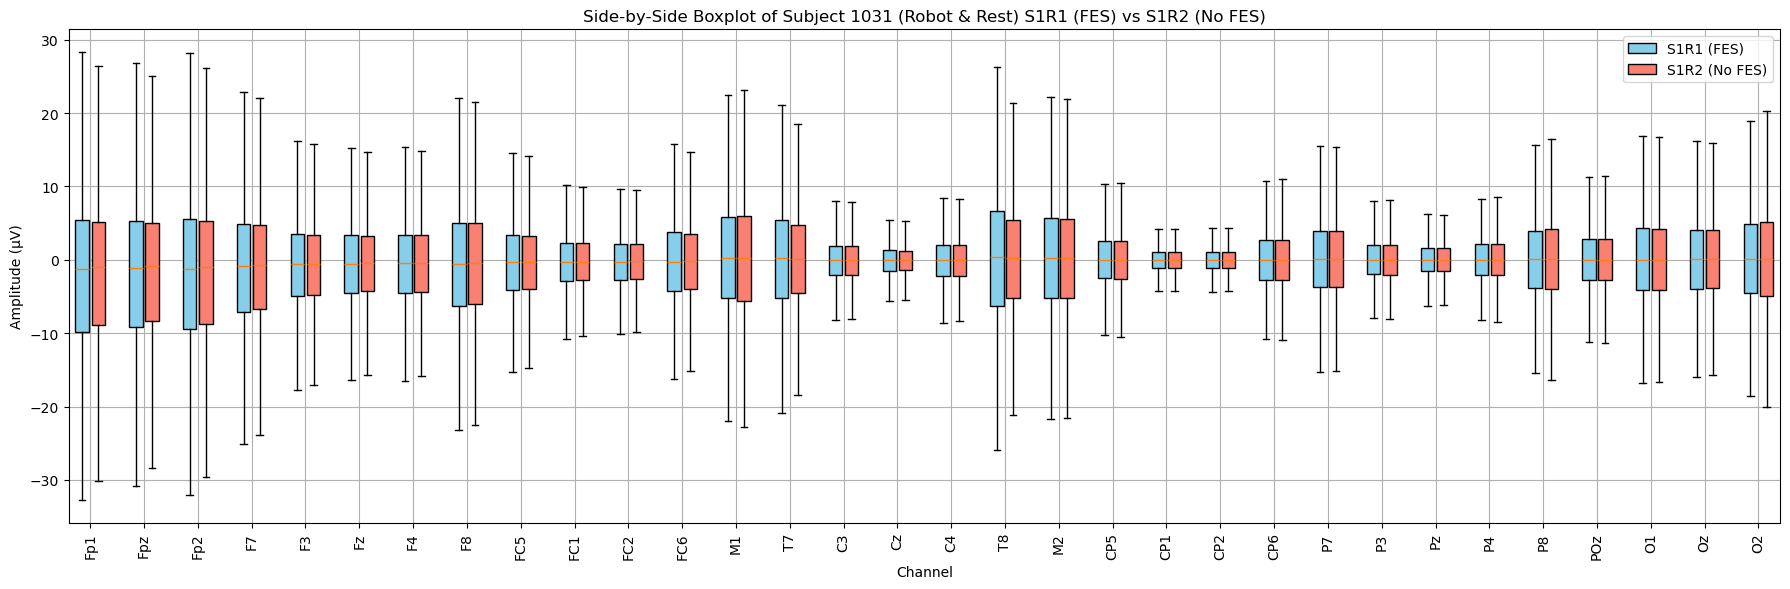

In [28]:
eeg_channels = [col for col in subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1031 S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1031 (Trial & Rest) S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

eeg_channels = [col for col in subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1031 (Robot & Rest) S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

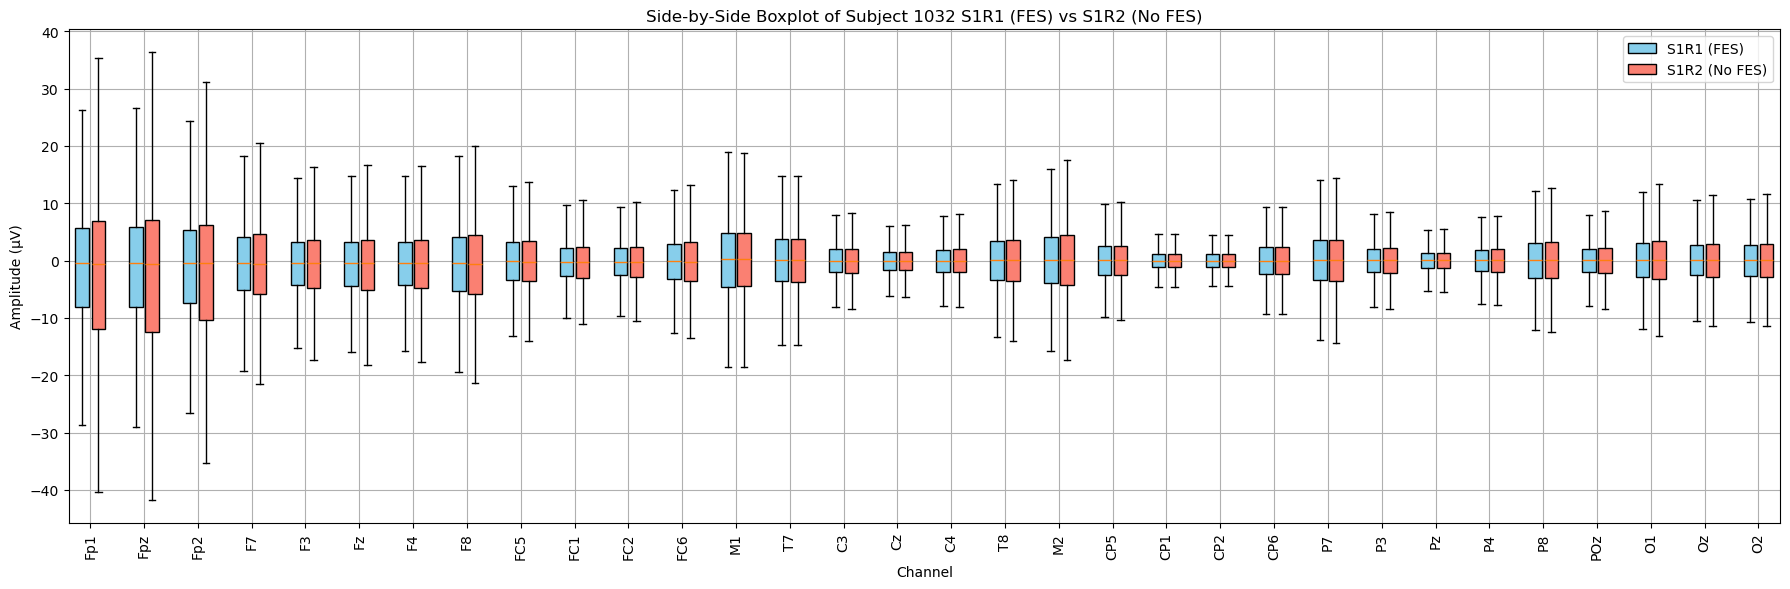

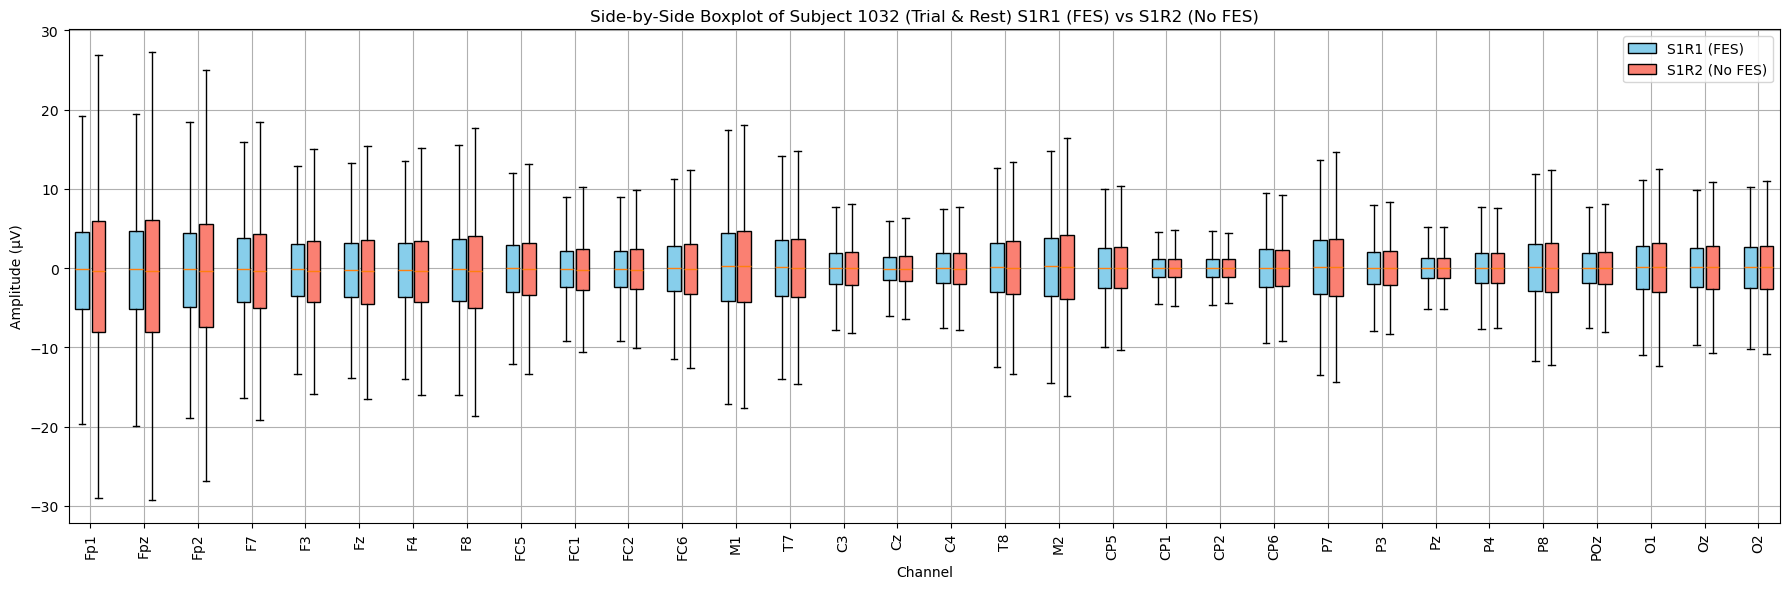

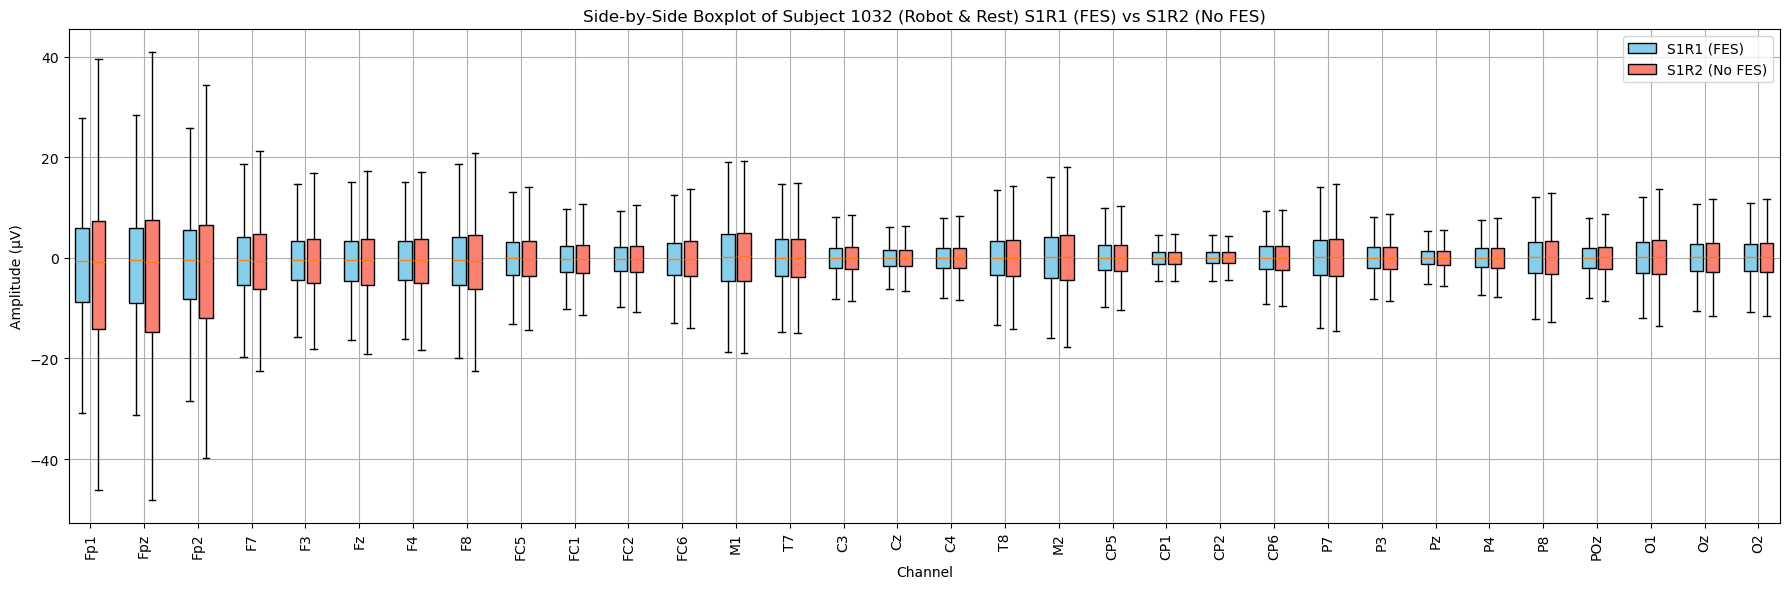

In [29]:
eeg_channels = [col for col in subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1032 S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1032 (Trial & Rest) S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

eeg_channels = [col for col in subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1032 (Robot & Rest) S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

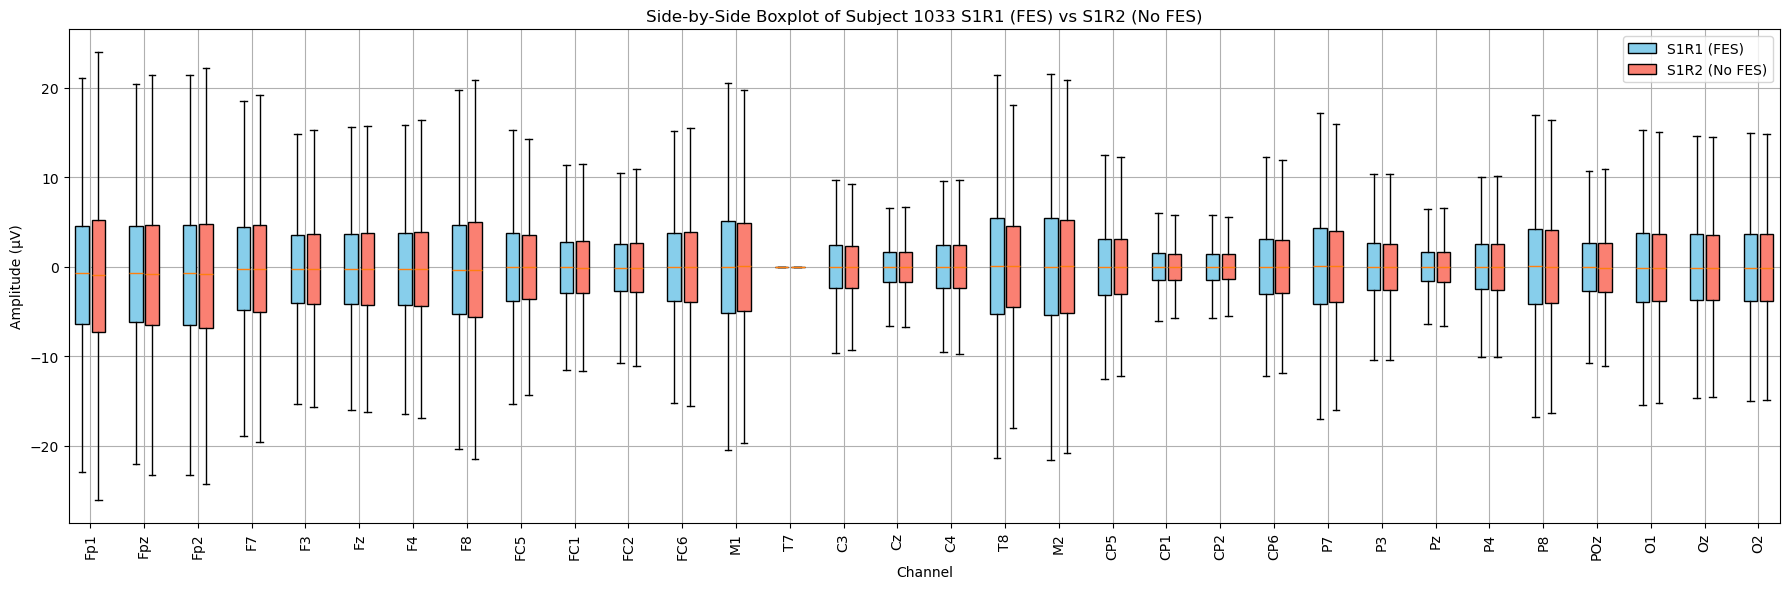

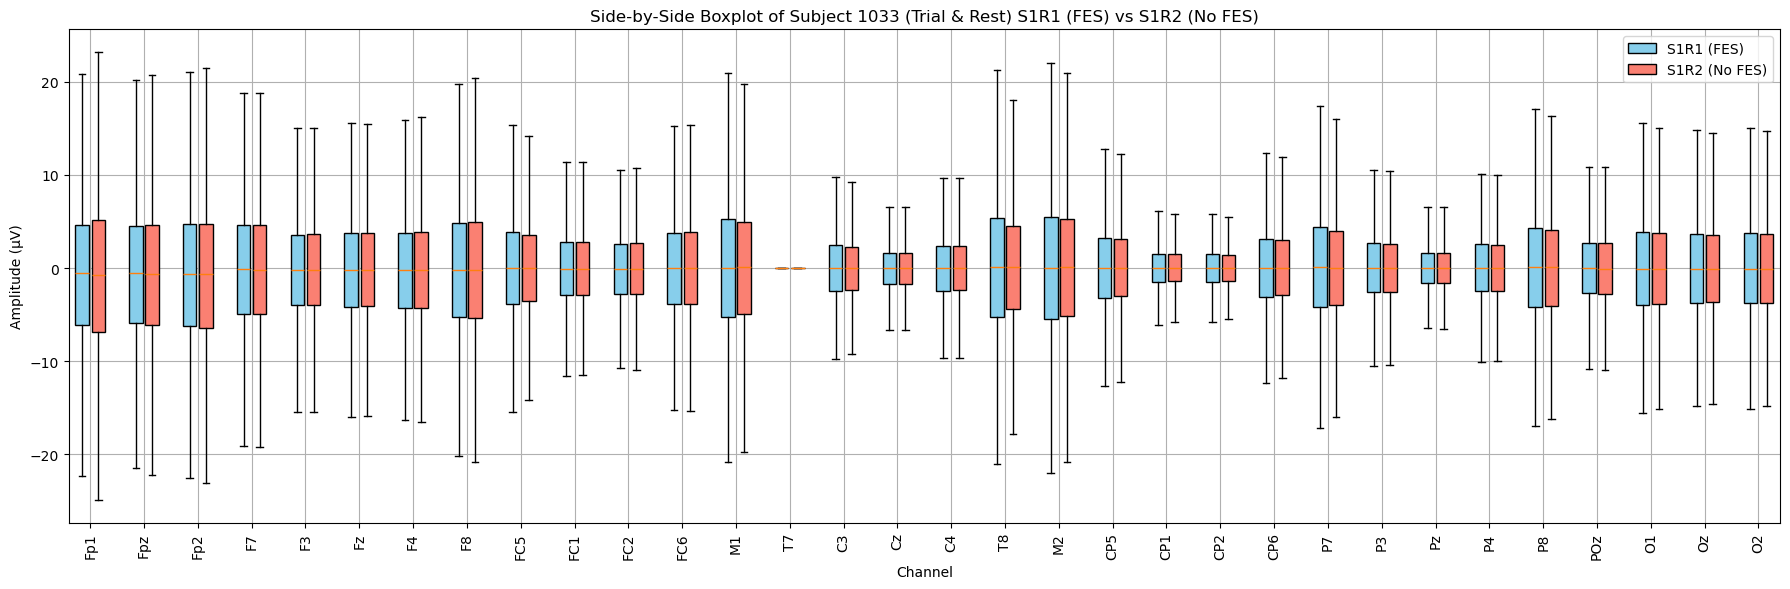

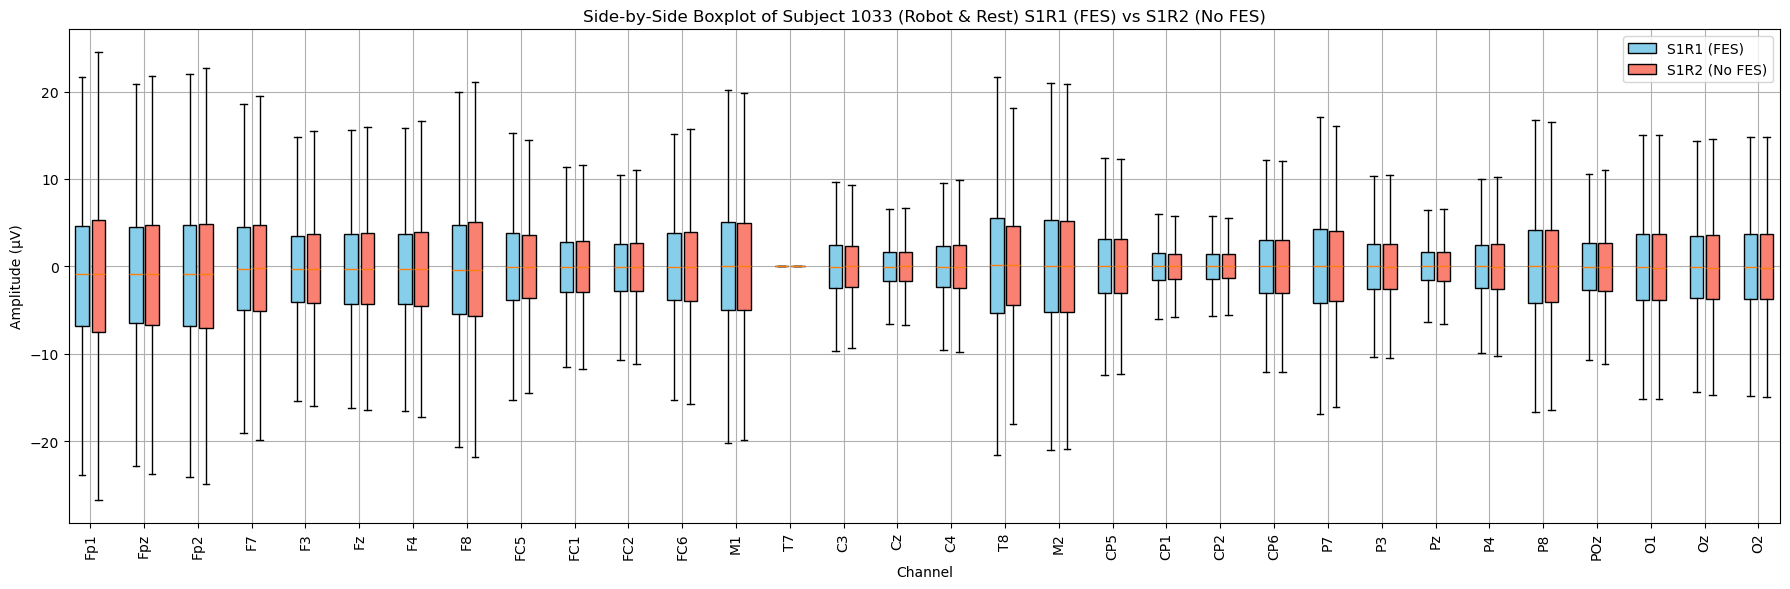

In [30]:
eeg_channels = [col for col in subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1033 S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

eeg_channels = [col for col in subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1033 (Trial & Rest) S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

eeg_channels = [col for col in subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if col in channels]

# Data from both runs
run1 = subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]
run2 = subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]

# Prepare data for boxplot
data_run1 = [run1[ch] for ch in eeg_channels]
data_run2 = [run2[ch] for ch in eeg_channels]

# X-axis positions
positions_run1 = np.arange(len(eeg_channels)) * 2.0  # space between channel pairs
positions_run2 = positions_run1 + 0.6                # offset for second run

# Create the figure
plt.figure(figsize=(18, 6))

# Plot Run 1 (e.g., FES)
bp1 = plt.boxplot(data_run1, positions=positions_run1, widths=0.5, patch_artist=True, showfliers=False)
for box in bp1['boxes']:
    box.set(facecolor='skyblue')

# Plot Run 2 (e.g., No FES)
bp2 = plt.boxplot(data_run2, positions=positions_run2, widths=0.5, patch_artist=True, showfliers=False)
for box in bp2['boxes']:
    box.set(facecolor='salmon')

# Set X-axis labels in between the paired boxplots
xtick_positions = (positions_run1 + positions_run2) / 2
plt.xticks(xtick_positions, eeg_channels, rotation=90)

# Titles and labels
plt.title('Side-by-Side Boxplot of Subject 1033 (Robot & Rest) S1R1 (FES) vs S1R2 (No FES)')
plt.xlabel('Channel')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()

# Legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S1R1 (FES)', 'S1R2 (No FES)'])

plt.show()

In [ ]:
subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects['Subj1031']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects['Subj1031']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1031']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects['Subj1031']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1031']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects['Subj1031']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects['Subj1032']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects['Subj1032']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1032']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects['Subj1032']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1032']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects['Subj1032']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects['Subj1033']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects['Subj1033']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1033']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects['Subj1033']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1033']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects['Subj1033']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

In [ ]:
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

In [ ]:
subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_robots_only['Subj1031']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_robots_only['Subj1031']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_robots_only['Subj1032']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_robots_only['Subj1032']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['Is_MI'] = subjects_robots_only['Subj1033']['Online']['Sessions'][0]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['Is_MI'] = subjects_robots_only['Subj1033']['Online']['Sessions'][1]['Runs'][1]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)
subjects_robots_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['Is_MI'] = subjects_robots_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]['OutcomeClass'].isin(['MI_BEGIN', 'MI_END']).astype(int)

In [ ]:
def extract_psd_features(eeg_df, sampling_rate, band_start=0, band_end=250, band_width=10):
    assert 'Trial' in eeg_df.columns, "'Trial' column is required in the input dataframe."
    channels = {'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8,' 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'OZ', 'O2', 'AUX1', 'AUX2', 'AUX3', 'AUX7', 'AUX8', 'AUX9'}
    channel_cols = [col for col in eeg_df.columns if col in channels]
    metadata_cols = [col for col in eeg_df.columns if col not in channel_cols]

    bands = np.arange(band_start, band_end, band_width)
    all_features = []

    for trial_id, trial_df in eeg_df.groupby('Trial'):
        trial_features = {'Trial': trial_id}
        eeg_data = trial_df[channel_cols].to_numpy().T  # shape: (n_channels, n_samples)
        f, Pxx = welch(eeg_data, fs=sampling_rate, nperseg=1024, axis=1)

        for ch_idx, ch_name in enumerate(channel_cols):
            for i in range(len(bands)):
                low = bands[i]
                high = low + band_width
                mask = (f >= low) & (f < high)
                band_power = np.mean(Pxx[ch_idx, mask]) if np.any(mask) else 0.0
                feature_name = f"{ch_name}_{low}-{high}Hz"
                trial_features[feature_name] = band_power

        for col in metadata_cols:
            trial_features[col] = trial_df[col].iloc[0]

        all_features.append(trial_features)

    return pd.DataFrame(all_features)


In [ ]:
subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].tail()

Time       Ch1       Ch2       Ch3       Ch4       Ch5  \
545447  24969.573116 -1.413300 -0.896360 -2.530110 -0.183647 -1.379659   
545448  24969.575069 -0.622654 -0.991351 -1.709980  0.004951 -1.889015   
545449  24969.577022  0.167134 -0.314054 -1.161722 -2.727544 -2.328947   
545450  24969.578976 -0.349320 -0.427106  0.625715 -2.800490 -1.551548   
545451  24969.580929 -0.076710 -0.031436 -0.117586 -0.097667 -0.047342   

             Ch6       Ch7       Ch8       Ch9  ...      Ch35       Ch36  \
545447 -1.010847 -1.722829 -1.296018 -1.276913  ... -2.532680  24.429336   
545448 -0.415559  0.305021  0.373593 -0.462708  ...  2.168347  24.457156   
545449 -1.352149 -0.752271  1.576807 -1.812527  ...  6.986606   0.802942   
545450 -0.578782 -0.184064  3.202571 -1.872213  ...  3.316493  -7.093825   
545451  0.034062  0.088131  0.087730 -0.031678  ...  0.452408   0.023708   

             Ch37      Ch38  Ch39  Label  OutcomeClass  Trial   FES  Is_MI  
545447  -2.539128 -5.040144   0.0    120      REST_END     60  True      0  
545448 -12.203816 -5.654416   0.0    120      REST_END     60  True      0  
545449   1.788590 -6.837603   0.0    120      REST_END     60  True      0  
545450  -5.742691 -0.910747   0.0    120      REST_END     60  True      0  
545451  -0.278318 -0.854691   0.0    120      REST_END     60  True      0  

[5 rows x 45 columns]

In [ ]:
subjects_banded_psd_trials_only = copy.deepcopy(subjects_trials_only)

subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0]= extract_psd_features(subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0], fs)

subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0]= extract_psd_features(subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0], fs)

subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1], fs)
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0], fs)
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0]= extract_psd_features(subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0], fs)

In [ ]:
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].head()

Trial    Ch1_0-10Hz  Ch1_10-20Hz  Ch1_20-30Hz  Ch1_30-40Hz  Ch1_40-50Hz  \
0      0  2.192051e-07     0.000122     0.018732     0.166524     0.199479   
1      1  1.889565e-05     0.000084     0.025271     0.141009     0.270139   
2      2  3.301623e-05     0.000205     0.053441     0.556442     1.063185   
3      3  3.172318e-06     0.000469     0.130896     0.334554     1.410348   
4      4  4.970567e-06     0.000083     0.017634     0.141930     0.204056   

   Ch1_50-60Hz  Ch1_60-70Hz  Ch1_70-80Hz  Ch1_80-90Hz  ...  Ch38_200-210Hz  \
0     0.108433     0.124670     0.144589     0.099056  ...        0.099978   
1     0.181152     0.198920     0.153758     0.163452  ...        0.206869   
2     0.605409     0.330409     0.239630     0.378194  ...        0.148482   
3     2.634427     1.045519     0.558225     0.587605  ...        0.130826   
4     0.173524     0.165527     0.149936     0.146961  ...        0.163374   

   Ch38_210-220Hz  Ch38_220-230Hz  Ch38_230-240Hz  Ch38_240-250Hz  \
0        0.133223        0.129647        0.107002        0.053391   
1        0.158005        0.097405        0.132547        0.088030   
2        0.131776        0.104677        0.087367        0.075643   
3        0.119095        0.107976        0.090389        0.066495   
4        0.123447        0.114190        0.095089        0.072568   

           Time  Label  OutcomeClass   FES  Is_MI  
0  23941.821764    200      MI_BEGIN  True      1  
1  23963.470271    100    REST_BEGIN  True      0  
2  23976.730079    200      MI_BEGIN  True      1  
3  23990.015278    200      MI_BEGIN  True      1  
4  24003.341493    100    REST_BEGIN  True      0  

[5 rows x 956 columns]

In [ ]:
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][1]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1031']['Offline']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]

subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][1]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1032']['Offline']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]

subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][1]['Runs'][1] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][0]['Runs'][0] != 0).any(axis=0)]
subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] = subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0].loc[:, (subjects_banded_psd_trials_only['Subj1033']['Offline']['Sessions'][1]['Runs'][0] != 0).any(axis=0)]

In [ ]:
def plot_correlation(df):
    channel_columns = [col for col in df.columns if col.startswith('Ch')]
    correlation_with_is_mi = df[channel_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

    correlation_with_is_mi = correlation_with_is_mi.reindex(correlation_with_is_mi.abs().sort_values(ascending=False).index)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")
    plt.title("Correlation of EEG Channels with 'Is_MI'")
    plt.ylabel("Pearson Correlation")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


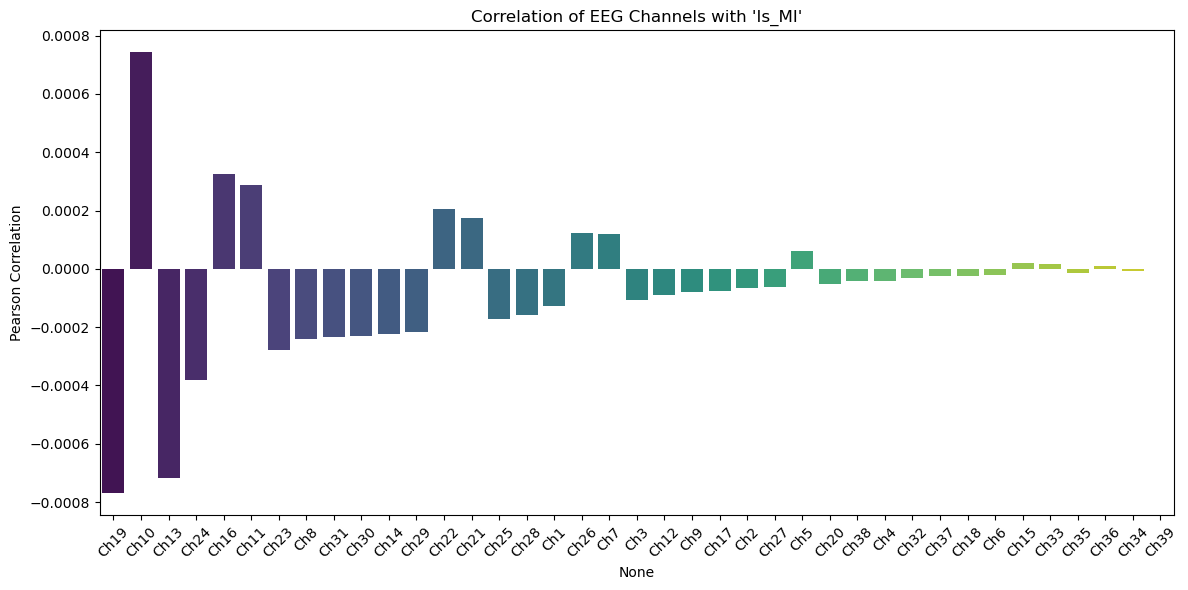

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


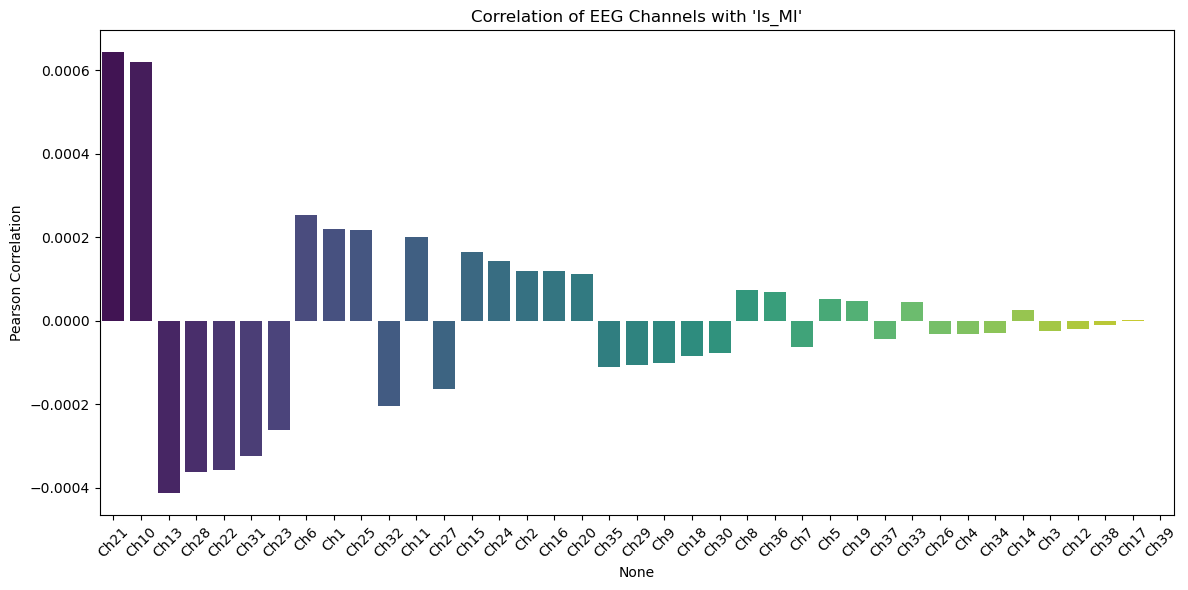

In [ ]:
plot_correlation(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0])
plot_correlation(subjects_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1])

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


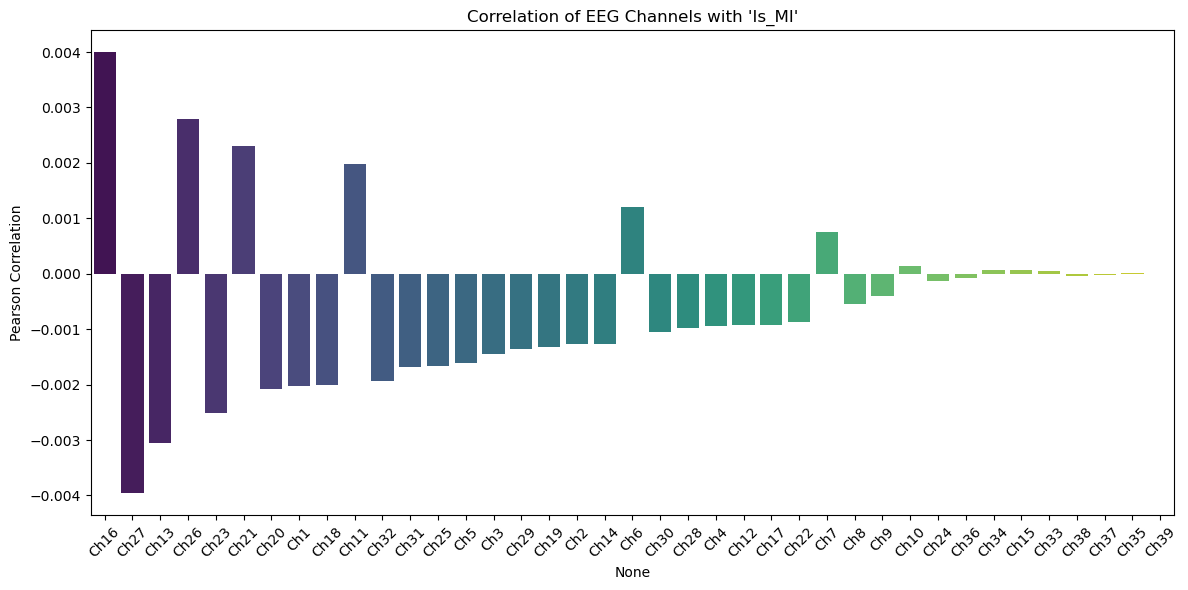

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


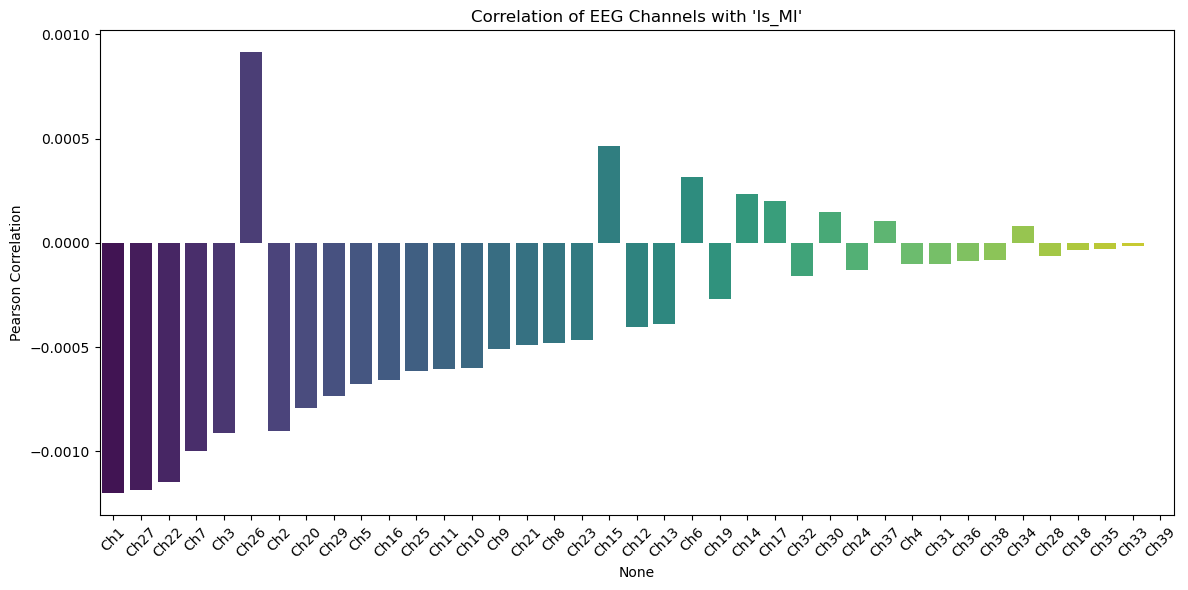

In [ ]:
plot_correlation(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0])
plot_correlation(subjects_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1])

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


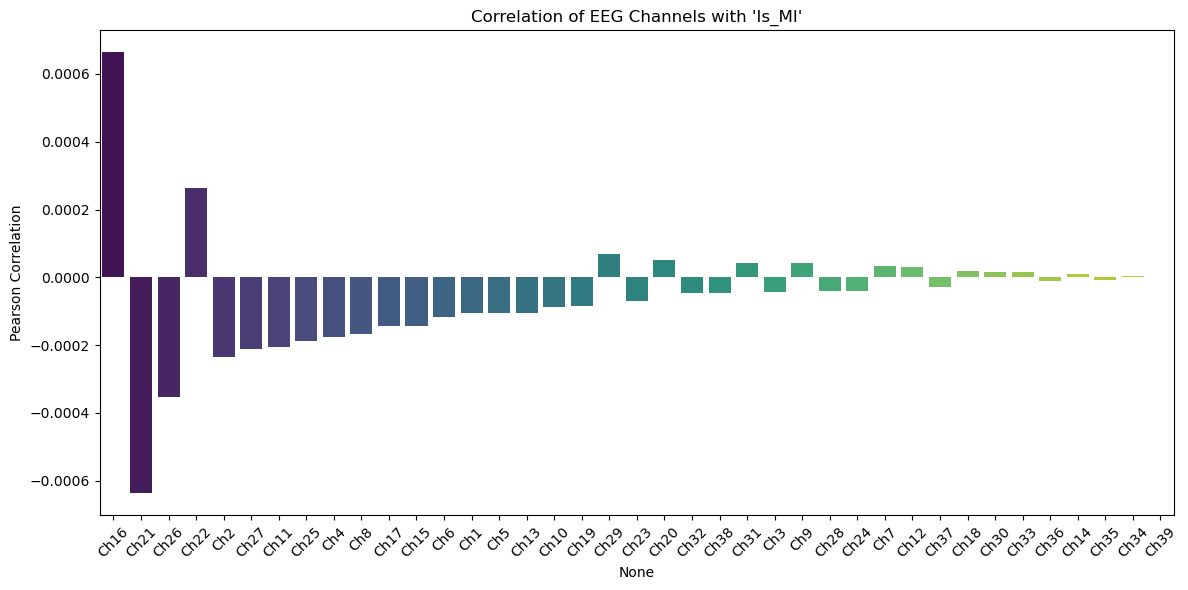

C:\Users\reece\AppData\Local\Temp\ipykernel_16836\22648127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_is_mi.index, y=correlation_with_is_mi.values, palette="viridis")


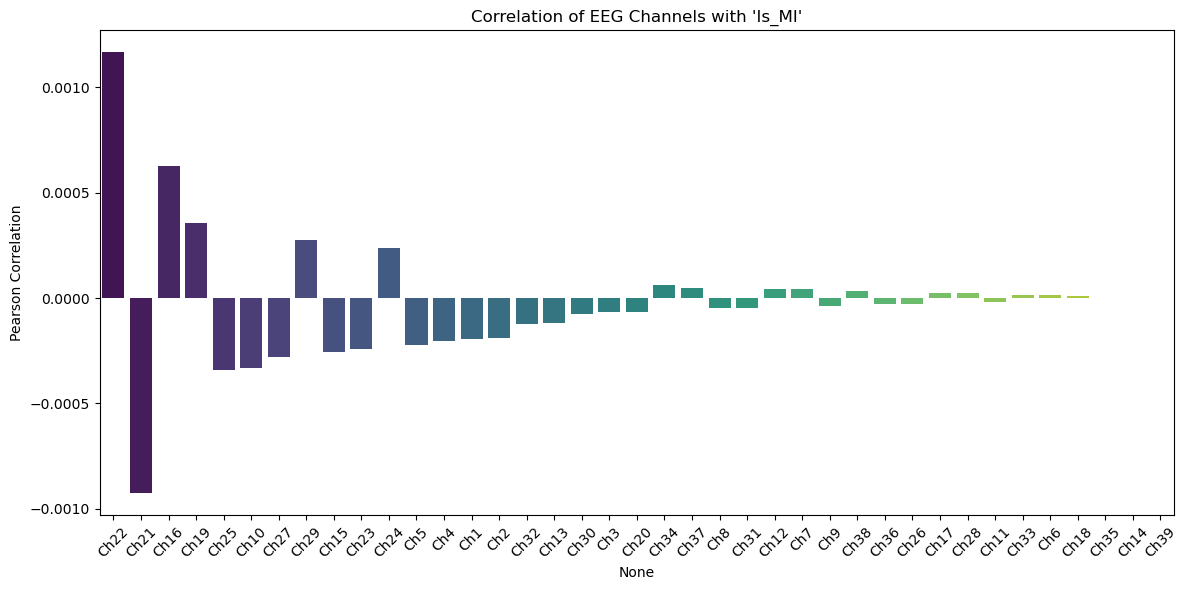

In [ ]:
plot_correlation(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0])
plot_correlation(subjects_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1])

In [ ]:
banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][0][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("Top 10 Correlations for Subject 1031 S1R1 (FES):")
print(top10_corr)

banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1031']['Online']['Sessions'][0]['Runs'][1][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("\nTop 10 Correlations for Subject 1031 S1R2 (No FES):")
print(top10_corr)

Top 10 Correlations for Subject 1031 S1R1 (FES):
Ch38_90-100Hz    -0.453670
Ch36_80-90Hz     -0.417868
Ch3_170-180Hz    -0.393649
Ch36_170-180Hz   -0.386314
Ch18_20-30Hz     -0.386176
Ch34_200-210Hz   -0.385852
Ch30_140-150Hz   -0.377909
Ch3_140-150Hz    -0.362719
Ch2_170-180Hz    -0.359234
Ch2_30-40Hz      -0.358934
Name: Is_MI, dtype: float64

Top 10 Correlations for Subject 1031 S1R2 (No FES):
Ch36_180-190Hz   -0.314965
Ch35_230-240Hz   -0.297138
Ch38_190-200Hz   -0.293404
Ch8_180-190Hz     0.291074
Ch7_130-140Hz     0.289913
Ch8_240-250Hz     0.289646
Ch3_200-210Hz     0.288923
Ch8_50-60Hz       0.288233
Ch7_100-110Hz     0.287170
Ch8_190-200Hz     0.286599
Name: Is_MI, dtype: float64


In [ ]:
banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][0][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("Top 10 Correlations for Subject 1032 S1R1 (FES):")
print(top10_corr)

banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1032']['Online']['Sessions'][0]['Runs'][1][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("\nTop 10 Correlations for Subject 1032 S1R2 (No FES):")
print(top10_corr)

Top 10 Correlations for Subject 1032 S1R1 (FES):
Ch37_210-220Hz    0.549200
Ch22_10-20Hz     -0.515924
Ch37_240-250Hz    0.514610
Ch28_10-20Hz     -0.512781
Ch10_20-30Hz     -0.511737
Ch37_180-190Hz    0.508669
Ch36_40-50Hz     -0.486367
Ch37_150-160Hz    0.479195
Ch5_30-40Hz      -0.475656
Ch10_40-50Hz     -0.470507
Name: Is_MI, dtype: float64

Top 10 Correlations for Subject 1032 S1R2 (No FES):
Ch27_10-20Hz     -0.557475
Ch23_10-20Hz     -0.550045
Ch2_70-80Hz      -0.499749
Ch22_10-20Hz     -0.489447
Ch37_120-130Hz   -0.453725
Ch1_20-30Hz      -0.438887
Ch3_70-80Hz      -0.430118
Ch21_10-20Hz     -0.420766
Ch2_20-30Hz      -0.414284
Ch6_20-30Hz      -0.410059
Name: Is_MI, dtype: float64


In [ ]:
banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][0][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("Top 10 Correlations for Subject 1033 S1R1 (FES):")
print(top10_corr)

banded_columns = [col for col in subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1].columns if 'Hz' in col]

# Compute correlation with Is_MI
band_corr = subjects_banded_psd_trials_only['Subj1033']['Online']['Sessions'][0]['Runs'][1][banded_columns + ['Is_MI']].corr()['Is_MI'].drop('Is_MI')

# Get top 10 most correlated features
top10_features = band_corr.abs().sort_values(ascending=False).head(10)

# Show feature names and their correlation values
top10_corr = band_corr.loc[top10_features.index]
print("\nTop 10 Correlations for Subject 1033 S1R2 (No FES):")
print(top10_corr)

Top 10 Correlations for Subject 1033 S1R1 (FES):
Ch22_10-20Hz     -0.476609
Ch16_10-20Hz     -0.458272
Ch36_180-190Hz    0.413496
Ch11_10-20Hz     -0.346479
Ch26_10-20Hz     -0.341583
Ch6_10-20Hz      -0.335381
Ch26_240-250Hz    0.334031
Ch17_10-20Hz     -0.332780
Ch26_200-210Hz    0.316300
Ch26_230-240Hz    0.315421
Name: Is_MI, dtype: float64

Top 10 Correlations for Subject 1033 S1R2 (No FES):
Ch22_10-20Hz   -0.511524
Ch15_10-20Hz   -0.491506
Ch10_10-20Hz   -0.437829
Ch5_10-20Hz    -0.437469
Ch16_20-30Hz   -0.399313
Ch21_10-20Hz   -0.395256
Ch2_10-20Hz    -0.394646
Ch17_10-20Hz   -0.383096
Ch3_10-20Hz    -0.377444
Ch24_10-20Hz   -0.367612
Name: Is_MI, dtype: float64


Next, combine sessions / runs / subjects and find correlations / fisher scores to compare

Later, we can also make models to find classification metrics when using FES/no FES (LOPO?)